In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import sys
import pickle
from scipy.optimize import curve_fit

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

import neurolib.dashboard.data as data
from neurolib.models.aln import ALNModel
import neurolib.dashboard.layout as layout
import neurolib.dashboard.functions as functions
from neurolib.utils import plotFunctions as plotFunc

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2    

not here


In [2]:
readpath = '.' + os.sep

with open(readpath + os.sep + 'bi.pickle','rb') as file:
    load_array= pickle.load(file)
ext_exc = load_array[0]
ext_inh = load_array[1]

with open(readpath + os.sep + 'bi_granular.pickle','rb') as file:
    load_array= pickle.load(file)
ext_exc_granular = load_array[0]
ext_inh_granular = load_array[1]

with open(readpath + os.sep + 'boundary_bi_granular.pickle','rb') as file:
    load_array= pickle.load(file)
boundary_exc_granular = load_array[0]
boundary_inh_granular = load_array[1]

grid_resolution = layout.grid_resolution
grid_resolution_granular = layout.grid_resolution_granular

dist_up_regime = np.zeros((len(ext_exc), 2))
dist_down_regime = np.zeros((len(ext_exc)))

cmap = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors()
exc_red = cmap(3)
inh_blue=cmap(0)
green = cmap(2)

aln = ALNModel()
data.set_parameters(aln)
state_vars = aln.state_vars

In [3]:
##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
def derivative(f,a,dt):
    return (f[a+1] - f[a])/dt

def fit_func_lin(x, a, b):
    return a * x + b

def fit_func_quad(x, a, b, c):
    return a * x**2 + b * x + c

def setlabels(axc):
    axc[-1,0].set_xlabel('Ext current to exc node')
    axc[-1,1].set_xlabel('Ext current to inh node')
    axc[-1,2].set_xlabel('Distance horizontal')
    axc[-1,3].set_xlabel('Distance vertical')
    axc[-1,4].set_xlabel('Shortest distance')
    axc[-1,5].set_xlabel('Exc target rate')
    axc[-1,6].set_xlabel('Inh target rate')

    axc[0,0].set_ylabel('Exc amplitude')
    axc[1,0].set_ylabel('Inh amplitude')
    axc[2,0].set_ylabel('Exc sparsity cost')
    axc[3,0].set_ylabel('Inh sparsity cost')
    axc[4,0].set_ylabel('Exc width')
    axc[5,0].set_ylabel('Inh width')
    
def setlabels_energy(axc):
    for i in [1, 4, 7]:
        axc[i,0].set_xlabel('Ext current to exc node')
        axc[i,1].set_xlabel('Ext current to inh node')
        axc[i,2].set_xlabel('Distance horizontal')
        axc[i,3].set_xlabel('Distance vertical')
        axc[i,4].set_xlabel('Shortest distance')
        axc[i,5].set_xlabel('Exc target rate')
        axc[i,6].set_xlabel('Inh target rate')

    axc[0,0].set_ylabel('Exc amplitude')
    axc[1,0].set_ylabel('Inh amplitude')
    axc[3,0].set_ylabel('Exc energy cost')
    axc[4,0].set_ylabel('Inh energy cost')
    axc[6,0].set_ylabel('Exc width')
    axc[7,0].set_ylabel('Inh width')
    
    for x in [2, 5, 8]:
        for y in [0,1]:
            axc[x,y].set_xlabel('Shortest distance')
            
    axc[2,2].set_xlabel('Inh amplitude')
    axc[2,0].set_ylabel('Amplitude sum')
    axc[2,1].set_ylabel('Amplitude geometric sum')
    axc[2,2].set_ylabel('Exc amplitude')
    
    axc[5,2].set_xlabel('Inh energy cost')
    axc[5,0].set_ylabel('Energy cost sum')
    axc[5,1].set_ylabel('Energy cost geometric sum')
    axc[5,2].set_ylabel('Exc energy cost')
    axc[5,3].set_xlabel('Total cost')
    axc[5,3].set_ylabel('Exc cost')
    axc[5,4].set_xlabel('Total cost')
    axc[5,4].set_ylabel('Inh cost')
    
    axc[8,2].set_xlabel('Inh width')
    axc[8,0].set_ylabel('Width sum')
    axc[8,1].set_ylabel('Width geometric sum')
    axc[8,2].set_ylabel('Exc width')

In [23]:
def readcase(case_):
    
    global ind_, type_, mu_e, mu_i, a_ee, a_ei, a_ie, a_ii, cost_node, w_ee, w_ei, w_ie, w_ii, target_high, target_low 
    global d_e, d_i, d_total, ufp_e, ufp_i, cost_tot
    global cost_p_x, cost_p_y, cost_s_ee, cost_s_ei, cost_s_ie, cost_s_ii, cost_e_ee, cost_e_ei, cost_e_ie, cost_e_ii
    global target_h_e, target_h_i, target_l_e, target_l_i, target_diff_e, target_diff_i
    
    readpath = '.' + os.sep + 'data_final_rate' + os.sep
    
    data_array = data.read_data_1(aln, readpath, case_)
    ind_, type_, mu_e, mu_i, a_, cost_node, w_, target_high, target_low = data_array
        
    opt_control = [None] * len(ind_)
    opt_state = [None] * len(ind_)
    
    control_data = data.read_control(readpath, case_)
    opt_control = control_data[2]
    opt_state = control_data[3]
        
    d_e = [None] * len(ind_)
    d_i = [None] * len(ind_)
    a_ee = [None] * len(ind_)
    a_ei = [None] * len(ind_)
    a_ie = [None] * len(ind_)
    a_ii = [None] * len(ind_)
    w_ee = [None] * len(ind_)
    w_ei = [None] * len(ind_)
    w_ie = [None] * len(ind_)
    w_ii = [None] * len(ind_)
    d_total = [None] * len(ind_)
    ufp_e = [None] * len(ind_)
    ufp_i = [None] * len(ind_)
    cost_tot = [None] * len(ind_)

    target_h_e = [None] * len(ind_)
    target_h_i = [None] * len(ind_)
    target_l_e = [None] * len(ind_)
    target_l_i = [None] * len(ind_)
    target_diff_e = [None] * len(ind_)
    target_diff_i = [None] * len(ind_)
    
    cost_p_x = [None] * len(ext_exc)
    cost_p_y = [None] * len(ext_exc)
    cost_s_ee = [None] * len(ext_exc)
    cost_e_ee = [None] * len(ext_exc)
    cost_s_ei = [None] * len(ext_exc)
    cost_e_ei = [None] * len(ext_exc)
    cost_s_ie = [None] * len(ext_exc)
    cost_e_ie = [None] * len(ext_exc)
    cost_s_ii = [None] * len(ext_exc)
    cost_e_ii = [None] * len(ext_exc)
        
    for i in ind_:
        
        if type(opt_control[i]) == type(None) or type_[i] == 6:
            continue
            
        print(i, type_[i])
                        
        a_ee[i] = a_[2,i]
        a_ei[i] = a_[3,i]
        a_ie[i] = a_[4,i]
        a_ii[i] = a_[5,i]
        
        w_ee[i] = w_[2,i]
        w_ei[i] = w_[3,i]
        w_ie[i] = w_[4,i]
        w_ii[i] = w_[5,i]
    
        if case_ in ['1', '2']:
            d_e[i] = data.dist_right(mu_e[i], mu_i[i], ext_exc_granular, ext_inh_granular, grid_resolution)
            d_i[i] = data.dist_low(mu_e[i], mu_i[i], ext_exc_granular, ext_inh_granular, grid_resolution)
            d_total[i] = data.dist_up_regime(mu_e[i], mu_i[i], boundary_exc_granular, boundary_inh_granular,
                                                   grid_resolution_granular)
            ufp = data.get_ufp(opt_state[i], 0)[0]
        else:
            d_e[i] = data.dist_left(mu_e[i], mu_i[i], ext_exc_granular, ext_inh_granular, grid_resolution)
            d_i[i] = data.dist_up(mu_e[i], mu_i[i], ext_exc_granular, ext_inh_granular, grid_resolution)
            d_total[i] = data.dist_down_regime(mu_e[i], mu_i[i], boundary_exc_granular, boundary_inh_granular,
                                               grid_resolution_granular)
                            
            ufp = data.get_ufp(opt_state[i], 2)[0]

        if ufp[0] > 1e-1  and ufp[1] > 1e-1:
            ufp_e[i] = ufp[0]
            ufp_i[i] = ufp[1]
            
        if type(w_ee[i]) == type(None) or a_ee[i] < 1e-8:
            w_ee[i] = 0.
        if type(w_ei[i]) == type(None) or a_ei[i] < 1e-8:
            w_ei[i] = 0.
        if type(w_ie[i]) == type(None) or a_ie[i] < 1e-8:
            w_ie[i] = 0.
        if type(w_ii[i]) == type(None) or a_ii[i] < 1e-8:
            w_ii[i] = 0.
            
        cost_p_x[i] = cost_node[i][0][0][0]
        cost_p_y[i] = cost_node[i][0][0][1]
        
        cost_s_ee[i] = cost_node[i][2][0][2]
        cost_e_ee[i] = cost_node[i][1][0][2]
        cost_s_ei[i] = cost_node[i][2][0][3]
        cost_e_ei[i] = cost_node[i][1][0][3]
        cost_s_ie[i] = cost_node[i][2][0][4]
        cost_e_ie[i] = cost_node[i][1][0][4]
        cost_s_ii[i] = cost_node[i][2][0][5]
        cost_e_ii[i] = cost_node[i][1][0][5]
        
        if case_ in ['1', '3']:
            cost_tot[i] = sum(cost_node[i][0][0][:]) + sum(cost_node[i][2][0][:])
        else:
            cost_tot[i] = sum(cost_node[i][0][0][:]) + sum(cost_node[i][1][0][:])
        
        if cost_s_ie[i] > 1.:
            print(i, mu_e[i], mu_i[i])
            print(cost_node[i])

        target_h_e[i] = target_high[i][0]
        target_h_i[i] = target_high[i][1]
        target_l_e[i] = target_low[i][0]
        target_l_i[i] = target_low[i][1]
        target_diff_e[i] = target_high[i][0] - target_low[i][0]
        target_diff_i[i] = target_high[i][1] - target_low[i][1]

In [67]:
#########################################
readcase('1')

case =  ./data_final_rate/ 1
case =  ./data_final_rate/ 1
0 2
1 2
2 2
3 2
4 2
5 2
6 2
9 2
12 2
18 2
20 2
21 2
24 2
30 2
33 2
36 2
42 2
45 2
48 2
50 2
54 2
57 2
60 2
66 2
69 2
72 2


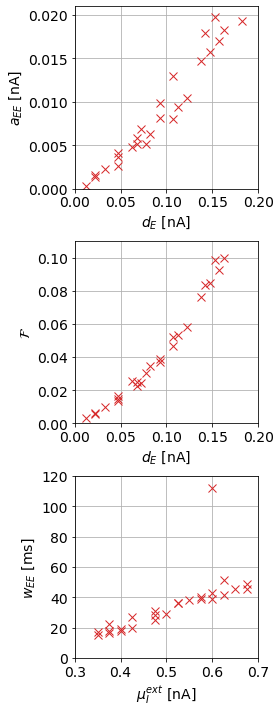

In [68]:
fig0, ax = plt.subplots(3,1, figsize = (4,10), facecolor='white')
fontsize_ = 14

for i in range(len(d_e)):
    if type(a_ee[i]) == type(None):
        continue
        
    if np.abs(a_ee[i]) > np.abs(a_ii[i]):
        ax[0].plot(d_e[i], np.abs(a_ee[i]), marker='x', color=exc_red, markersize=markersize_, linestyle='')
        ax[1].plot(d_e[i], cost_tot[i], marker='x', color=exc_red, markersize=markersize_, linestyle='')
        ax[2].plot(mu_i[i], w_ee[i], marker='x', color=exc_red, markersize=markersize_, linestyle='')

legend_elements = []
legend_elements.append(Line2D([], [], marker='x', color=exc_red, linestyle='', label='E'))
      
"""
for [x_,y_] in [[0,2], [1,3], [2,2], [3,3]]:
    if x_ in [0,2]:
        color_ = exc_red
    else:
        color_ = inh_blue

    label_ = ('({:.2f} '.format(fit_data[x_][y_][0][0]) + r'$\pm$' + ' {:.2f}'.format(fit_data[x_][y_][1][0,0])
                      + r')$\cdot x +$ ' + ' ({:.2f} '.format(fit_data[x_][y_][0][1]) + r'$\pm$'
                      + ' {:.2f}'.format(fit_data[x_][y_][1][1,1])
                      + ')'
                    )
    plotfig = 0
    if x_ >= 2:
        plotfig = 1
        
    ax[plotfig].plot(x_ranges[y_], fit_func_lin(x_ranges[y_], fit_data[x_][y_][0][0], fit_data[x_][y_][0][1]),
                   color=color_, label = label_)
    ax[plotfig].fill_between(x_ranges[y_], fit_func_lin(x_ranges[y_],
                fit_data[x_][y_][0][0] - fit_data[x_][y_][1][0,0], fit_data[x_][y_][0][1] - fit_data[x_][y_][1][1,1]),
                fit_func_lin(x_ranges[y_],
                fit_data[x_][y_][0][0] + fit_data[x_][y_][1][0,0], fit_data[x_][y_][0][1] + fit_data[x_][y_][1][1,1]),
                color=color_, alpha=0.2)
    
    legend_elements.append(Line2D([], [], color=color_, label=label_))
"""

for i in range(3):
    ax[i].tick_params(axis='x', labelsize=fontsize_)
    ax[i].tick_params(axis='y', labelsize=fontsize_)
ax[0].set_xlabel(r'$d_E$ [nA]', fontsize=fontsize_)
ax[0].set_ylabel(r'$a_{EE}$ [nA]', fontsize=fontsize_)
ax[1].set_xlabel(r'$d_E$ [nA]', fontsize=fontsize_)
ax[1].set_ylabel(r'$\mathcal{F}$', fontsize=fontsize_)
ax[2].set_xlabel(r'$\mu_I^{ext}$ [nA]', fontsize=fontsize_)
ax[2].set_ylabel(r'$w_{EE}$ [ms]', fontsize=fontsize_)

#col = 'Task 1: Low to high, sparsity constraints'    
#ax[1].annotate(col, xy=(0.5, 1.0), xytext=(0,5), xycoords='axes fraction', textcoords='offset points',
#               size=14, ha='center', va='baseline')

"""
fig0.legend(handles=legend_elements, fontsize=fontsize_, loc='upper left', bbox_to_anchor=(0.0, 1.15), ncol = 3, 
              handletextpad=0.1, columnspacing=1.)
"""

ax[0].set_xlim(0., 0.2)
ax[0].set_ylim(0., 0.021)
ax[0].set_xticks(np.arange(0., 0.25, 0.05))

ax[1].set_xlim(0., 0.2)
ax[1].set_ylim(0., 0.11)
ax[1].set_xticks(np.arange(0., 0.25, 0.05))

ax[2].set_xlim(0.3, 0.7)
ax[2].set_ylim(0., 120.)
#ax[2].set_xticks(np.arange(60., 130, 20))

fig0.tight_layout()
    
plt.savefig( os.path.join(os.getcwd(), 'rate_1'), facecolor=fig0.get_facecolor(), edgecolor='none',
            bbox_inches = 'tight', dpi=600)

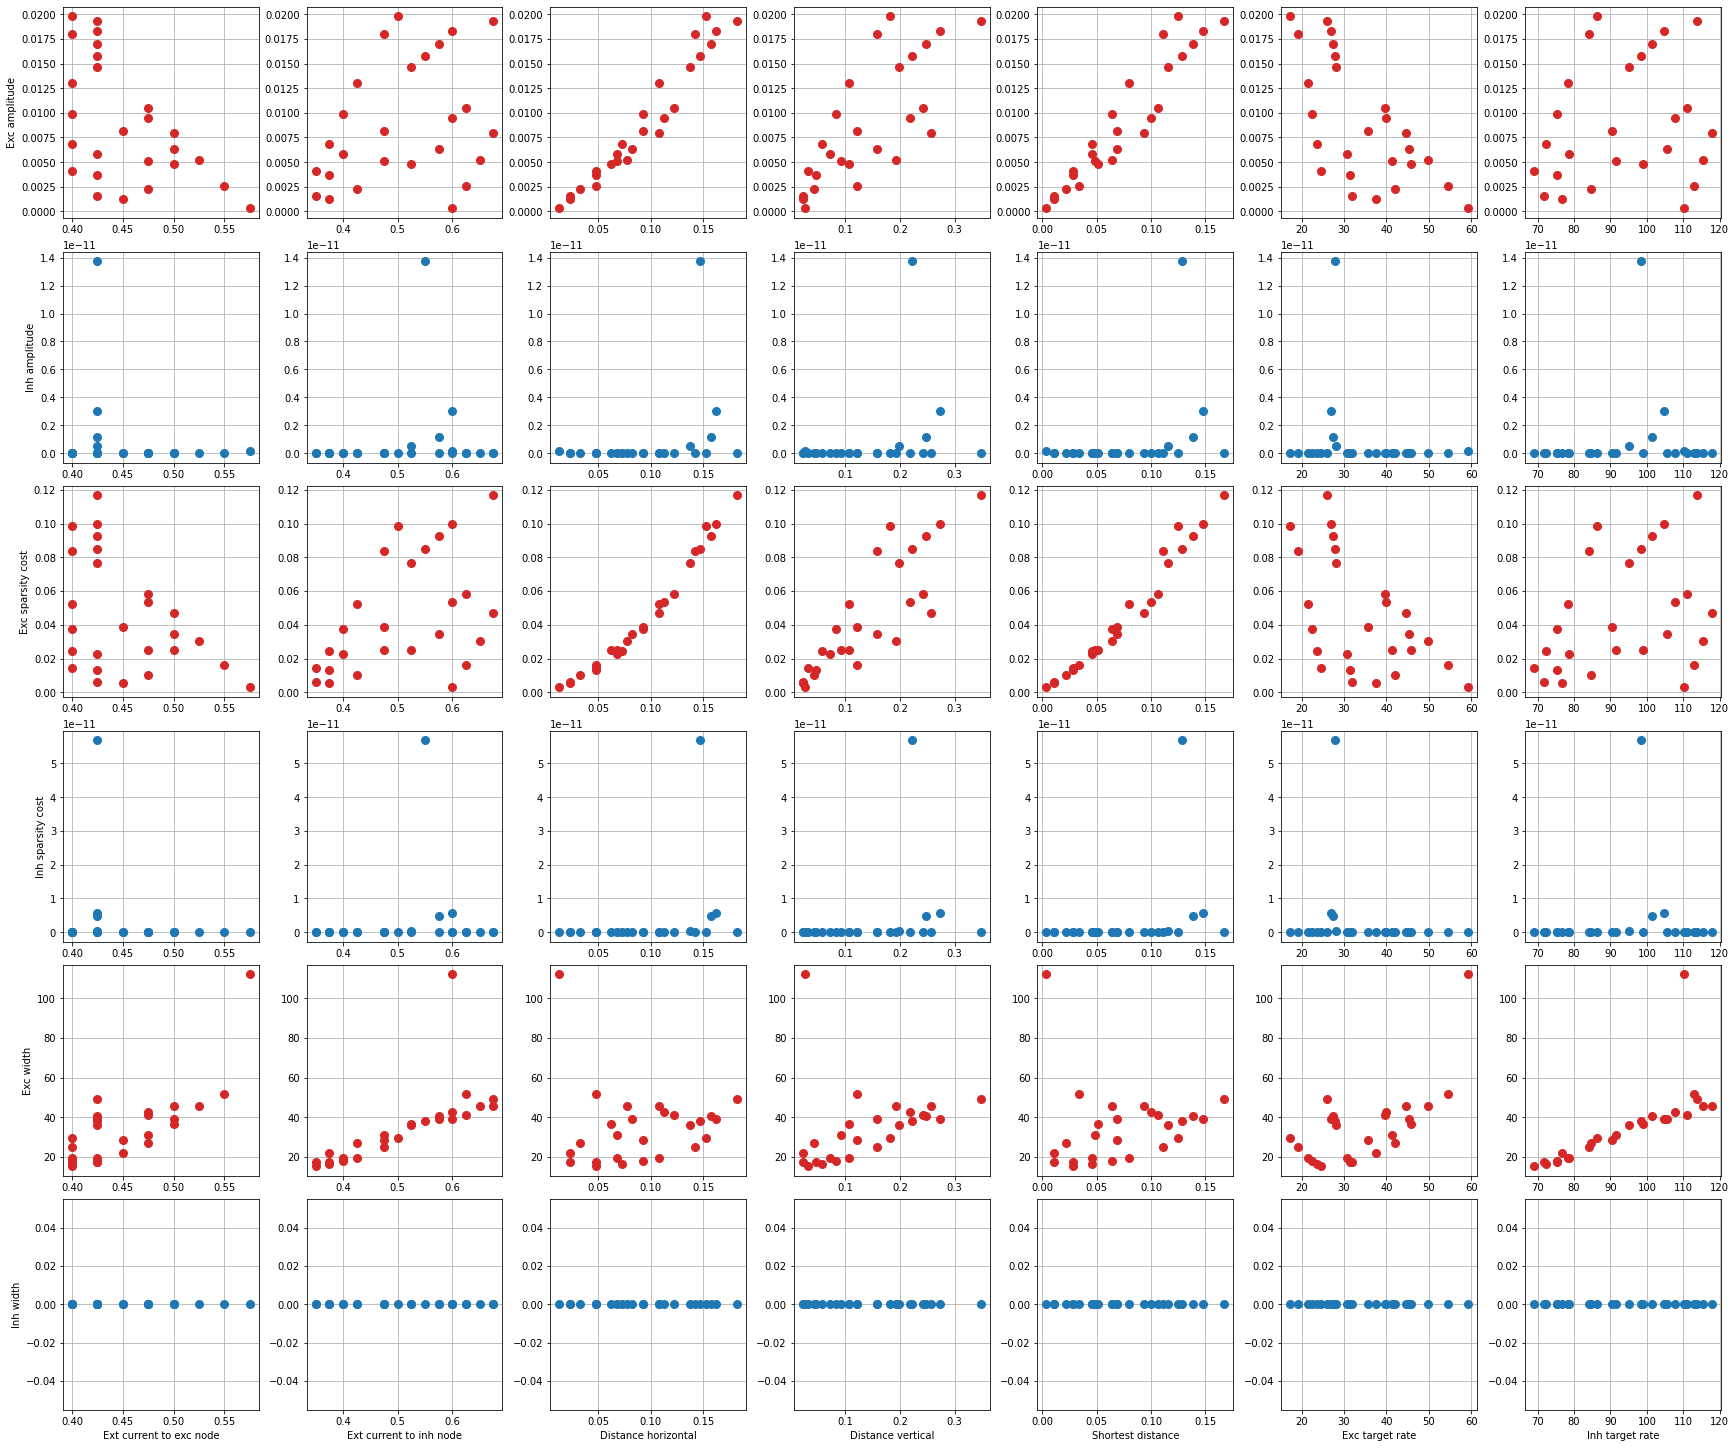

In [64]:
fig5c, axc = plt.subplots(6,7, constrained_layout=True, figsize = (24,20) )

markersize_ = 8

y_axis = [a_ee, a_ii, cost_s_ee, cost_s_ii, w_ee, w_ii]
x_axis = [mu_e, mu_i, d_e, d_i, d_total, target_h_e, target_h_i]

fit_data_y_e = [[], [], [], [], [], []]
fit_data_y_i = [[], [], [], [], [], []]
fit_data_x_e = [[], [], [], [], [], [], []]
fit_data_x_i = [[], [], [], [], [], [], []]

fit_data = [[[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]]]

#fit_data[6][7][2]= 1.

for i in range(len(d_e)):
    if type(a_ee[i]) == type(None):
        continue

    if np.abs(a_ii[i]) > np.abs(a_ee[i]):
        marker_ = 'x'
    else:
        marker_ = 'o'
        
    for x_ in range(len(x_axis)):
        x_data = x_axis[x_][i]
        if np.abs(a_ii[i]) > np.abs(a_ee[i]):
            fit_data_x_i[x_].append(x_data)
        elif np.abs(a_ii[i]) <= np.abs(a_ee[i]):
            fit_data_x_e[x_].append(x_data)
                
    for y_ in range(len(y_axis)):
        
        if y_ in [0,2,4]:
            color_ = exc_red
        else:
            color_ = inh_blue
        
        y_data = np.abs(y_axis[y_][i])
        if np.abs(a_ii[i]) > np.abs(a_ee[i]):
            fit_data_y_i[y_].append(y_data)
        elif np.abs(a_ii[i]) <= np.abs(a_ee[i]):
            fit_data_y_e[y_].append(y_data)
        
        for x_ in range(len(x_axis)):
            x_data = x_axis[x_][i]
        
            axc[y_,x_].plot(x_data, y_data, marker=marker_, color=color_, markersize=markersize_)
            
x_min_max = [[np.amin(x_) - 0.02, np.amax(x_) + 0.02] for x_ in fit_data_x_e]
x_ranges = [np.arange(x_min_max[x_][0], x_min_max[x_][1], 0.01) for x_ in range(len(x_min_max))]

"""

for x_ in range(len(x_axis)):
    for y_ in range(len(y_axis)):
        
        if y_ in [4,5]:
            continue
        
        if y_ in [0,2]:
            if len(fit_data_x_e[x_]) > 0:
                color_ = exc_red
                popt, pcov = curve_fit(fit_func_lin, fit_data_x_e[x_], fit_data_y_e[y_])
            else:
                continue
        else:
            if len(fit_data_x_i[x_]) > 0:
                color_ = inh_blue
                popt, pcov = curve_fit(fit_func_lin, fit_data_x_i[x_], fit_data_y_i[y_])
            else:
                continue
                        
        fit_data[y_][x_][0] = popt
        fit_data[y_][x_][1] = pcov
        label_ = ('({:.2f} '.format(fit_data[y_][x_][0][0]) + r'$\pm$' + ' {:.2f}'.format(fit_data[y_][x_][1][0,0])
                  + r')$\cdot x $+ ' + ' ({:.2f} '.format(fit_data[y_][x_][0][1]) + r'$\pm$'
                  + ' {:.2f} '.format(fit_data[y_][x_][1][1,1])
                  + ')'
                )
        axc[y_,x_].plot(x_ranges[x_], fit_func_lin(x_ranges[x_], fit_data[y_][x_][0][0], fit_data[y_][x_][0][1]),
                       color=color_, label = label_)
        axc[y_,x_].fill_between(x_ranges[x_], fit_func_lin(x_ranges[x_],
                fit_data[y_][x_][0][0] - fit_data[y_][x_][1][0,0], fit_data[y_][x_][0][1] - fit_data[y_][x_][1][1,1]),
                fit_func_lin(x_ranges[x_],
                fit_data[y_][x_][0][0] + fit_data[y_][x_][1][0,0], fit_data[y_][x_][0][1] + fit_data[y_][x_][1][1,1]),
                color=color_, alpha=0.2)
        
        axc[y_,x_].set_xlim(x_min_max[x_])
        axc[y_,x_].legend(loc='upper right')
        
plot_yellow = [[0,2], [1,3], [2,2], [3,3], [4,2], [4,4], [5,2], [5,3], [5,4]]

for i in range(len(plot_yellow)):
    axc[plot_yellow[i][0], plot_yellow[i][1]].patch.set_facecolor('yellow')
    axc[plot_yellow[i][0], plot_yellow[i][1]].patch.set_alpha(0.3)
"""

setlabels(axc)

       
plt.savefig( os.path.join(os.getcwd(), 'A_all_1.png') )
plt.show()

In [55]:
#########################################
readcase('3')

case =  ./data_final_rate/ 3
case =  ./data_final_rate/ 3
0 3
1 3
2 3
3 3
5 3
6 3
9 3
10 3
13 3
14 3
18 3
19 3
24 3
25 3
30 3
36 3
42 3
48 3
55 3
62 3
69 3
76 3


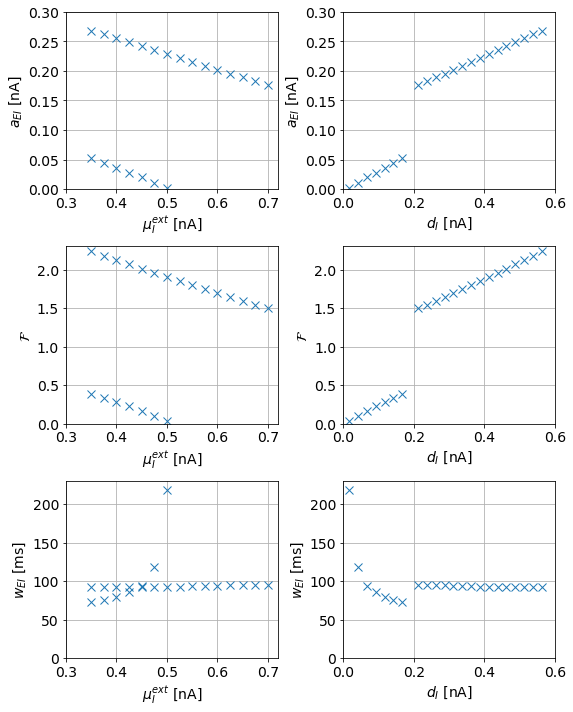

In [54]:
fig0, ax = plt.subplots(3,2, figsize = (8,10), facecolor='white')
fontsize_ = 14

for i in range(len(d_i)):
    if type(a_ei[i]) == type(None):
        continue
        
    if np.abs(a_ei[i]) > np.abs(a_ie[i]):
        ax[0,0].plot(mu_i[i], np.abs(a_ei[i]), marker='x', color=inh_blue, markersize=markersize_, linestyle='')
        ax[1,0].plot(mu_i[i], cost_tot[i], marker='x', color=inh_blue, markersize=markersize_, linestyle='')
        ax[2,0].plot(mu_i[i], w_ei[i], marker='x', color=inh_blue, markersize=markersize_, linestyle='')
        ax[0,1].plot(d_i[i], np.abs(a_ei[i]), marker='x', color=inh_blue, markersize=markersize_, linestyle='')
        ax[1,1].plot(d_i[i], cost_tot[i], marker='x', color=inh_blue, markersize=markersize_, linestyle='')
        ax[2,1].plot(d_i[i], w_ei[i], marker='x', color=inh_blue, markersize=markersize_, linestyle='')

legend_elements = []
legend_elements.append(Line2D([], [], marker='x', color=inh_blue, linestyle='', label='EI'))
      
"""
for [x_,y_] in [[0,2], [1,3], [2,2], [3,3]]:
    if x_ in [0,2]:
        color_ = exc_red
    else:
        color_ = inh_blue

    label_ = ('({:.2f} '.format(fit_data[x_][y_][0][0]) + r'$\pm$' + ' {:.2f}'.format(fit_data[x_][y_][1][0,0])
                      + r')$\cdot x +$ ' + ' ({:.2f} '.format(fit_data[x_][y_][0][1]) + r'$\pm$'
                      + ' {:.2f}'.format(fit_data[x_][y_][1][1,1])
                      + ')'
                    )
    plotfig = 0
    if x_ >= 2:
        plotfig = 1
        
    ax[plotfig].plot(x_ranges[y_], fit_func_lin(x_ranges[y_], fit_data[x_][y_][0][0], fit_data[x_][y_][0][1]),
                   color=color_, label = label_)
    ax[plotfig].fill_between(x_ranges[y_], fit_func_lin(x_ranges[y_],
                fit_data[x_][y_][0][0] - fit_data[x_][y_][1][0,0], fit_data[x_][y_][0][1] - fit_data[x_][y_][1][1,1]),
                fit_func_lin(x_ranges[y_],
                fit_data[x_][y_][0][0] + fit_data[x_][y_][1][0,0], fit_data[x_][y_][0][1] + fit_data[x_][y_][1][1,1]),
                color=color_, alpha=0.2)
    
    legend_elements.append(Line2D([], [], color=color_, label=label_))
"""

for i in range(3):
    for j in range(2):
        ax[i,j].tick_params(axis='x', labelsize=fontsize_)
        ax[i,j].tick_params(axis='y', labelsize=fontsize_)
    
ax[0,0].set_xlabel(r'$\mu_I^{ext}$ [nA]', fontsize=fontsize_)
ax[0,0].set_ylabel(r'$a_{EI}$ [nA]', fontsize=fontsize_)
ax[1,0].set_xlabel(r'$\mu_I^{ext}$ [nA]', fontsize=fontsize_)
ax[1,0].set_ylabel(r'$\mathcal{F}$', fontsize=fontsize_)
ax[2,0].set_xlabel(r'$\mu_I^{ext}$ [nA]', fontsize=fontsize_)
ax[2,0].set_ylabel(r'$w_{EI}$ [ms]', fontsize=fontsize_)

ax[0,1].set_xlabel(r'$d_I$ [nA]', fontsize=fontsize_)
ax[0,1].set_ylabel(r'$a_{EI}$ [nA]', fontsize=fontsize_)
ax[1,1].set_xlabel(r'$d_I$ [nA]', fontsize=fontsize_)
ax[1,1].set_ylabel(r'$\mathcal{F}$', fontsize=fontsize_)
ax[2,1].set_xlabel(r'$d_I$ [nA]', fontsize=fontsize_)
ax[2,1].set_ylabel(r'$w_{EI}$ [ms]', fontsize=fontsize_)

#col = 'Task 1: Low to high, sparsity constraints'    
#ax[1].annotate(col, xy=(0.5, 1.0), xytext=(0,5), xycoords='axes fraction', textcoords='offset points',
#               size=14, ha='center', va='baseline')

"""
fig0.legend(handles=legend_elements, fontsize=fontsize_, loc='upper left', bbox_to_anchor=(0.0, 1.15), ncol = 3, 
              handletextpad=0.1, columnspacing=1.)
"""

for i in range(3):
    ax[i,0].set_xlim(0.3, 0.72)
    ax[i,1].set_xlim(0., 0.6)
    
for j in range(2):
    ax[0,j].set_ylim(0., 0.3)
    ax[1,j].set_ylim(0., 2.3)
    ax[2,j].set_ylim(0., 230)
    
#ax[0,0].set_ylim(0., 0.021)
#ax[0,0].set_xticks(np.arange(0., 0.25, 0.05))

#ax[1,0].set_xlim(0., 0.2)
#ax[1,0].set_ylim(0., 0.11)
#ax[1,0].set_xticks(np.arange(0., 0.25, 0.05))

#ax[2,0].set_xlim(0.3, 0.7)
#ax[2,0].set_ylim(0., 120.)
#ax[2,0].set_xticks(np.arange(60., 130, 20))

#ax[0,0].set_xlim(0., 0.2)
#ax[0,0].set_ylim(0., 0.021)
#ax[0,0].set_xticks(np.arange(0., 0.25, 0.05))

#ax[1,0].set_xlim(0., 0.2)
#ax[1,0].set_ylim(0., 0.11)
#ax[1,0].set_xticks(np.arange(0., 0.25, 0.05))

#ax[2,0].set_xlim(0.3, 0.7)
#ax[2,0].set_ylim(0., 120.)
#ax[2,0].set_xticks(np.arange(60., 130, 20))

fig0.tight_layout()
    
plt.savefig( os.path.join(os.getcwd(), 'rate_3'), facecolor=fig0.get_facecolor(), edgecolor='none',
            bbox_inches = 'tight', dpi=600)

0
1
2
3
5
6
9
10
13
14
18
19
24
25
30
36
42
48
55
62
69
76


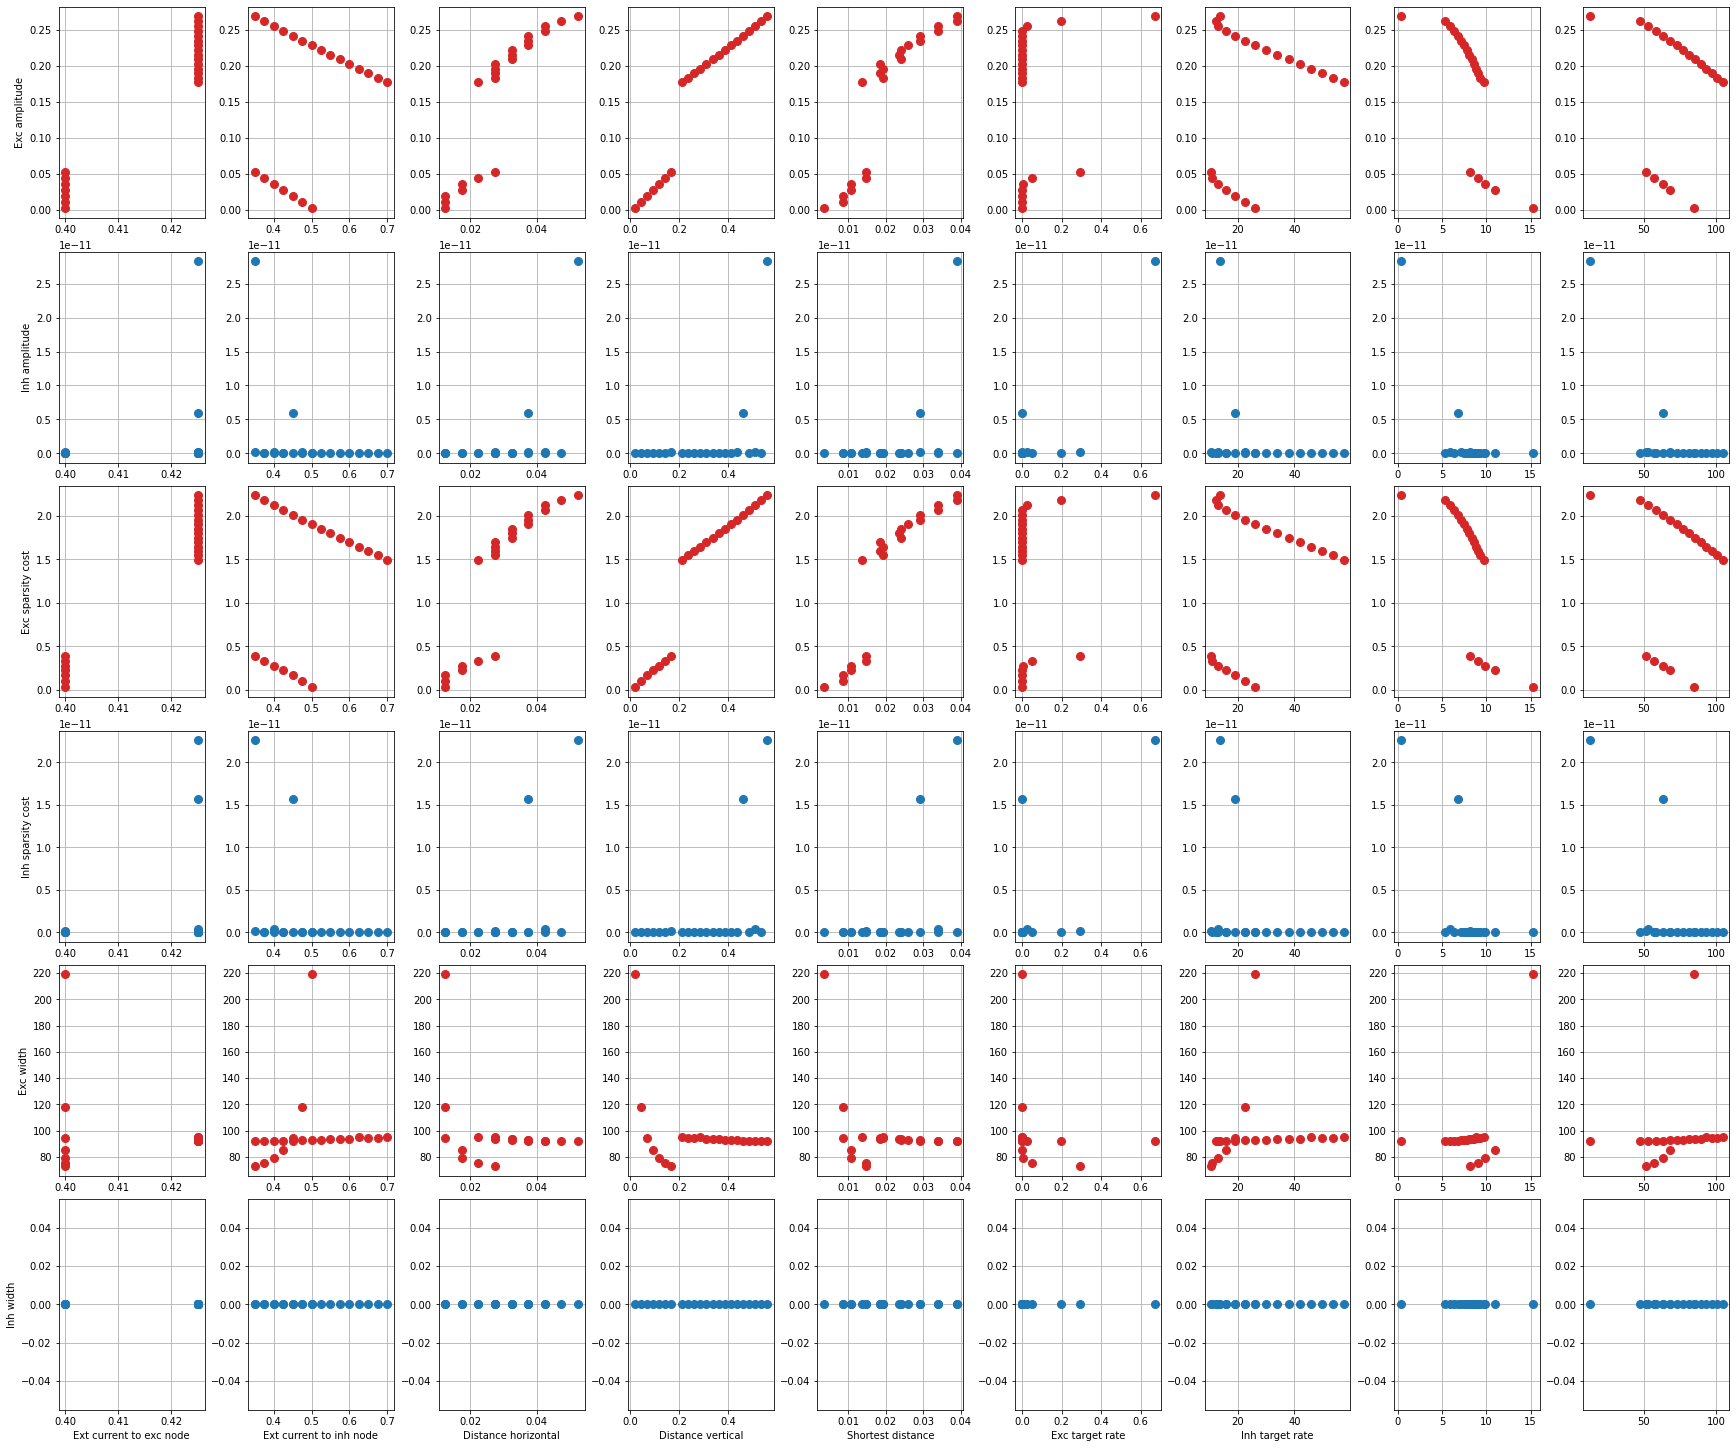

In [14]:
fig5c, axc = plt.subplots(6,9, constrained_layout=True, figsize = (24,20), facecolor='white')
markersize_ = 8

y_axis = [a_ei, a_ie, cost_s_ei, cost_s_ie, w_ei, w_ie]
x_axis = [mu_e, mu_i, d_e, d_i, d_total, target_l_e, target_l_i,
            ufp_e, ufp_i]
          #target_l_e, target_l_i, target_diff_e, target_diff_i]

fit_data_y_e = [[], [], [], [], [], []]
fit_data_y_i = [[], [], [], [], [], []]
fit_data_x_e = [[], [], [], [], [], [], []]
fit_data_x_i = [[], [], [], [], [], [], []]

fit_data = [[[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]]]

#fit_data[6][7][2]= 1.

for i in range(len(d_e)):
    if type(a_ei[i]) == type(None):
        continue

    if np.abs(a_ie[i]) > np.abs(a_ei[i]):
        marker_ = 'x'
    else:
        marker_ = 'o'
        
    for x_ in range(len(x_axis)):
        x_data = x_axis[x_][i]
        
        """
        if np.abs(a_ie[i]) > np.abs(a_ei[i]):
            fit_data_x_i[x_].append(x_data)
        elif np.abs(a_ie[i]) <= np.abs(a_ei[i]):
            fit_data_x_e[x_].append(x_data)
        """
        
    for y_ in range(len(y_axis)):
        
        if y_ in [1,3,5]:
            color_ = exc_red
        else:
            color_ = inh_blue
        
        y_data = np.abs(y_axis[y_][i])
        """
        if np.abs(a_ie[i]) > np.abs(a_ei[i]):
            fit_data_y_i[y_].append(y_data)
        elif np.abs(a_ie[i]) <= np.abs(a_ei[i]):
            fit_data_y_e[y_].append(y_data)
        """
        
        for x_ in range(len(x_axis)):
            x_data = x_axis[x_][i]
            if type(x_data) == type(None):
                continue
        
            axc[y_,x_].plot(x_data, y_data, marker=marker_, color=color_, markersize=markersize_)

"""
x_min_max = [[np.amin(x_) - 0.02, np.amax(x_) + 0.02] for x_ in fit_data_x_e]
x_ranges = [np.arange(x_min_max[x_][0], x_min_max[x_][1], 0.01) for x_ in range(len(x_min_max))]


for x_ in range(len(x_axis)):
    for y_ in range(len(y_axis)):
        
        if y_ in [1,3,4,5]:
            continue
        
        color_ = exc_red
        popt, pcov = curve_fit(fit_func_lin, fit_data_x_e[x_], fit_data_y_e[y_])
                        
        fit_data[y_][x_][0] = popt
        fit_data[y_][x_][1] = pcov
        label_ = ('({:.2f} '.format(fit_data[y_][x_][0][0]) + r'$\pm$' + ' {:.2f}'.format(fit_data[y_][x_][1][0,0])
                  + r')$\cdot x $+ ' + ' ({:.2f} '.format(fit_data[y_][x_][0][1]) + r'$\pm$'
                  + ' {:.2f} '.format(fit_data[y_][x_][1][1,1])
                  + ')'
                )
        axc[y_,x_].plot(x_ranges[x_], fit_func_lin(x_ranges[x_], fit_data[y_][x_][0][0], fit_data[y_][x_][0][1]),
                       color=color_, label = label_)
        axc[y_,x_].fill_between(x_ranges[x_], fit_func_lin(x_ranges[x_],
                fit_data[y_][x_][0][0] - fit_data[y_][x_][1][0,0], fit_data[y_][x_][0][1] - fit_data[y_][x_][1][1,1]),
                fit_func_lin(x_ranges[x_],
                fit_data[y_][x_][0][0] + fit_data[y_][x_][1][0,0], fit_data[y_][x_][0][1] + fit_data[y_][x_][1][1,1]),
                color=color_, alpha=0.2)
        
        axc[y_,x_].set_xlim(x_min_max[x_])
        axc[y_,x_].legend(loc='upper right')

        
plot_yellow = [[0,2], [2,2], [4,2], [4,4]]

for i in range(len(plot_yellow)):
    axc[plot_yellow[i][0], plot_yellow[i][1]].patch.set_facecolor('yellow')
    axc[plot_yellow[i][0], plot_yellow[i][1]].patch.set_alpha(0.3)
"""

setlabels(axc)
       
plt.savefig( os.path.join(os.getcwd(), 'A_all_3.png') )
plt.show()

In [73]:
#########################################
readcase('2')

case =  ./data_final_rate/ 2
case =  ./data_final_rate/ 2
0 2
1 2
2 2
3 2
4 2
5 2
6 2
9 2
12 2
18 2
21 2
23 2
24 2
30 2
33 2
34 2
36 2
42 2
45 2
48 2
54 2
56 2
57 2
60 2
66 2
67 2
69 2
72 2


correlation coefficient:  [[1.         0.88573789]
 [0.88573789 1.        ]]
[[1.         0.41053357]
 [0.41053357 1.        ]]
[[1.         0.62438575]
 [0.62438575 1.        ]]


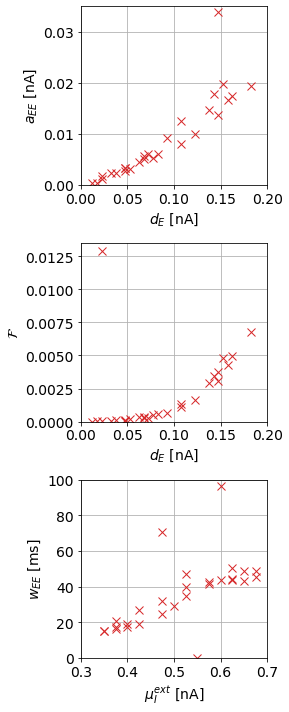

In [74]:
fig0, ax = plt.subplots(3,1, figsize = (4,10), facecolor='white')
fontsize_ = 14

fit_ = [[],[],[],[],[]]

for i in range(len(d_e)):
    if type(a_ee[i]) == type(None):
        continue
        
    if np.abs(a_ee[i]) > np.abs(a_ii[i]):
        ax[0].plot(d_e[i], np.abs(a_ee[i]), marker='x', color=exc_red, markersize=markersize_, linestyle='')
        ax[1].plot(d_e[i], cost_tot[i], marker='x', color=exc_red, markersize=markersize_, linestyle='')
        ax[2].plot(mu_i[i], w_ee[i], marker='x', color=exc_red, markersize=markersize_, linestyle='')
        fit_[0].append(d_e[i])
        fit_[1].append(mu_i[i])
        fit_[2].append(np.abs(a_ee[i]))
        fit_[3].append(cost_tot[i])
        fit_[4].append(w_ee[i])
        

legend_elements = []
legend_elements.append(Line2D([], [], marker='x', color=exc_red, linestyle='', label='E'))

for i in range(3):
    ax[i].tick_params(axis='x', labelsize=fontsize_)
    ax[i].tick_params(axis='y', labelsize=fontsize_)
ax[0].set_xlabel(r'$d_E$ [nA]', fontsize=fontsize_)
ax[0].set_ylabel(r'$a_{EE}$ [nA]', fontsize=fontsize_)
ax[1].set_xlabel(r'$d_E$ [nA]', fontsize=fontsize_)
ax[1].set_ylabel(r'$\mathcal{F}$', fontsize=fontsize_)
ax[2].set_xlabel(r'$\mu_I^{ext}$ [nA]', fontsize=fontsize_)
ax[2].set_ylabel(r'$w_{EE}$ [ms]', fontsize=fontsize_)

#col = 'Task 1: Low to high, sparsity constraints'    
#ax[1].annotate(col, xy=(0.5, 1.0), xytext=(0,5), xycoords='axes fraction', textcoords='offset points',
#               size=14, ha='center', va='baseline')

"""
fig0.legend(handles=legend_elements, fontsize=fontsize_, loc='upper left', bbox_to_anchor=(0.0, 1.15), ncol = 3, 
              handletextpad=0.1, columnspacing=1.)
"""

ax[0].set_xlim(0., 0.2)
ax[0].set_ylim(0., 0.035)
#ax[0].set_xticks(np.arange(0., 0.25, 0.05))

ax[1].set_xlim(0., 0.2)
ax[1].set_ylim(0., 0.0135)
#ax[1].set_xticks(np.arange(0., 0.25, 0.05))

ax[2].set_xlim(0.3, 0.7)
ax[2].set_ylim(0., 100.)
#ax[2].set_xticks(np.arange(60., 130, 20))

fig0.tight_layout()
    
plt.savefig( os.path.join(os.getcwd(), 'rate_2'), facecolor=fig0.get_facecolor(), edgecolor='none',
            bbox_inches = 'tight', dpi=600)

print( 'correlation coefficient: ', np.corrcoef( fit_[0], fit_[2])  )
print(np.corrcoef( fit_[0], fit_[3]))
print(np.corrcoef( fit_[1], fit_[4]))

case =  ./data_final_rate/ 2
case =  ./data_final_rate/ 2


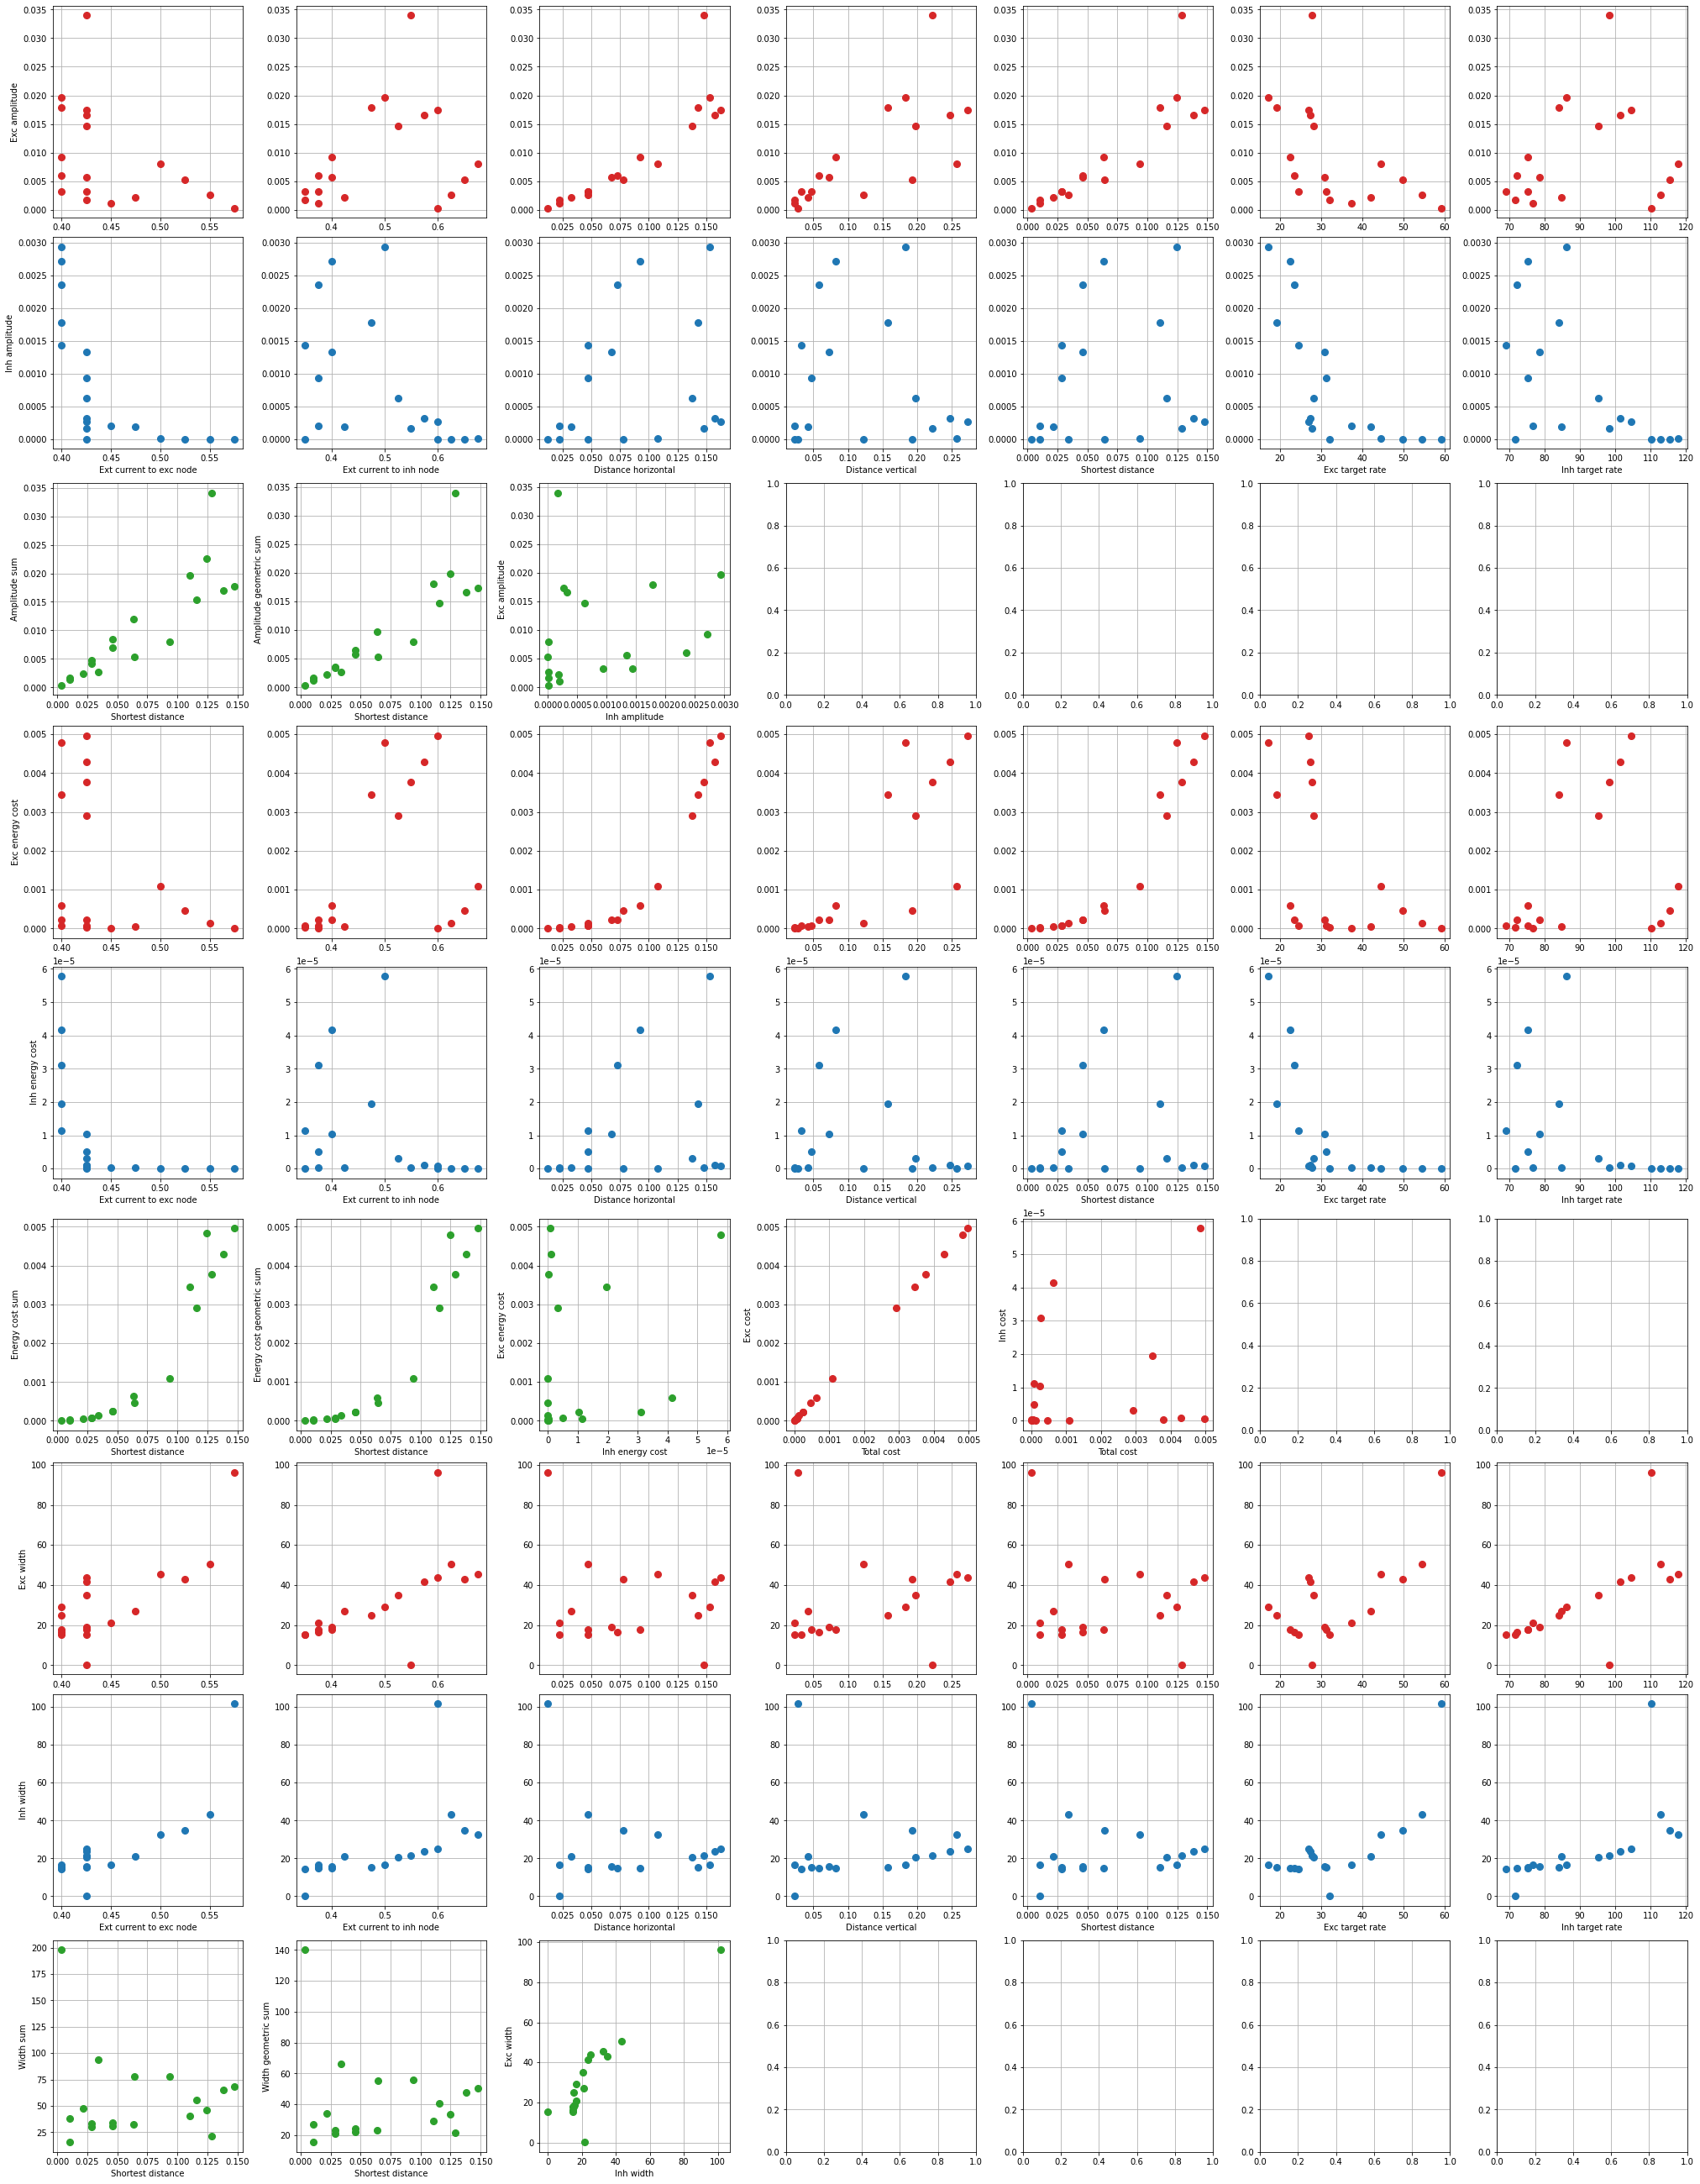

In [35]:
fig5c, axc = plt.subplots(9,7, constrained_layout=True, figsize = (28,36) ) # width, height

markersize_ = 8

y_axis = [a_ee, a_ii, cost_e_ee, cost_e_ii, w_ee, w_ii]
x_axis = [mu_e, mu_i, d_e, d_i, d_total, target_h_e, target_h_i]

fit_data_y_e = [[], [], [], [], [], []]
fit_data_y_i = [[], [], [], [], [], []]
fit_data_x_e = [[], [], [], [], [], [], []]
fit_data_x_i = [[], [], [], [], [], [], []]

fit_data_y_sum_e = [[], [], [], []]
fit_data_y_sum_i = [[], [], [], []]


fit_data_e = [[[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None, None], [None, None, None], [None, None, None], [None, None, None], [None, None, None],
                 [None, None, None], [None, None, None]],
            [[None, None, None], [None, None, None], [None, None, None], [None, None, None], [None, None, None],
                 [None, None, None], [None, None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]]]

fit_data_i = [[[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None, None], [None, None, None], [None, None, None], [None, None, None], [None, None, None],
                 [None, None, None], [None, None, None]],
            [[None, None, None], [None, None, None], [None, None, None], [None, None, None], [None, None, None],
                 [None, None, None], [None, None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]]]

fit_data_0 = [[[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None, None], [None, None, None], [None, None, None], [None, None, None], [None, None, None],
                 [None, None, None], [None, None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]]]

#fit_data[6][7][2]= 1.

for i in range(len(d_e)):
    if type(a_ee[i]) == type(None):
        continue

    if np.abs(a_ii[i]) > np.abs(a_ee[i]):
        marker_ = 'x'
        color_ = inh_blue
    else:
        marker_ = 'o'
        color_ = exc_red
        
    axc[5,3].plot(cost_e_ee[i] + cost_e_ii[i], cost_e_ee[i], marker=marker_, color=color_, markersize=markersize_)
    axc[5,4].plot(cost_e_ee[i] + cost_e_ii[i], cost_e_ii[i], marker=marker_, color=color_, markersize=markersize_)
        
    for x_ in range(len(x_axis)):
        x_data = x_axis[x_][i]
        if np.abs(a_ii[i]) > np.abs(a_ee[i]):
            fit_data_x_i[x_].append(x_data)
        elif np.abs(a_ii[i]) <= np.abs(a_ee[i]):
            fit_data_x_e[x_].append(x_data)
                
    for y_ in range(len(y_axis)):
        
        if y_ in [0,2,4]:
            color_ = exc_red
        else:
            color_ = inh_blue
        
        y_data = np.abs(y_axis[y_][i])
        if np.abs(a_ii[i]) > np.abs(a_ee[i]):
            fit_data_y_i[y_].append(y_data)
        elif np.abs(a_ii[i]) <= np.abs(a_ee[i]):
            fit_data_y_e[y_].append(y_data)
        
        for x_ in range(len(x_axis)):
            x_data = x_axis[x_][i]
            
            plot_y_ = y_
            if y_ > 1:
                plot_y_ += 1
            if y_ > 3:
                plot_y_ += 1
            axc[plot_y_,x_].plot(x_data, y_data, marker=marker_, color=color_, markersize=markersize_)
            
    axc[2,0].plot(d_total[i], np.abs(a_ee[i]) + np.abs(a_ii[i]), marker=marker_, color=green, markersize=markersize_)
    axc[2,1].plot(d_total[i], np.sqrt(a_ee[i]**2 + a_ii[i]**2), marker=marker_, color=green,
                  markersize=markersize_)
    axc[2,2].plot(np.abs(a_ii[i]), np.abs(a_ee[i]), marker=marker_, color=green, markersize=markersize_)
    
    
    if np.abs(a_ii[i]) > np.abs(a_ee[i]):
        fit_data_y_sum_i[0].append(np.abs(a_ee[i]) + np.abs(a_ii[i]))
        fit_data_y_sum_i[1].append(np.sqrt(a_ee[i]**2 + a_ii[i]**2))
    else:
        fit_data_y_sum_e[0].append(np.abs(a_ee[i]) + np.abs(a_ii[i]))
        fit_data_y_sum_e[1].append(np.sqrt(a_ee[i]**2 + a_ii[i]**2))
    
    axc[5,0].plot(d_total[i], cost_e_ee[i] + cost_e_ii[i], marker=marker_, color=green, markersize=markersize_)
    axc[5,1].plot(d_total[i], np.sqrt(cost_e_ee[i]**2 + cost_e_ii[i]**2), marker=marker_, color=green,
                  markersize=markersize_)
    axc[5,2].plot(cost_e_ii[i], cost_e_ee[i], marker=marker_, color=green, markersize=markersize_)
    
    if np.abs(a_ii[i]) > np.abs(a_ee[i]):
        fit_data_y_sum_i[2].append(np.abs(cost_e_ee[i]) + np.abs(cost_e_ii[i]))
        fit_data_y_sum_i[3].append(np.sqrt(cost_e_ee[i]**2 + cost_e_ii[i]**2))
    else:
        fit_data_y_sum_e[2].append(np.abs(cost_e_ee[i]) + np.abs(cost_e_ii[i]))
        fit_data_y_sum_e[3].append(np.sqrt(cost_e_ee[i]**2 + cost_e_ii[i]**2))
    
    axc[8,0].plot(d_total[i], w_ee[i] + w_ii[i], marker=marker_, color=green, markersize=markersize_)
    axc[8,1].plot(d_total[i], np.sqrt(w_ee[i]**2 + w_ii[i]**2), marker=marker_, color=green,
                  markersize=markersize_)
    axc[8,2].plot(w_ii[i], w_ee[i], marker=marker_, color=green, markersize=markersize_)
    
            
x_min_max = [[max(0., np.amin(x_) - 0.02), np.amax(x_) + 0.02] for x_ in fit_data_x_e]
x_ranges = [np.arange(x_min_max[x_][0], x_min_max[x_][1], 0.01) for x_ in range(len(x_min_max))]

"""
for x_ in range(len(x_axis)):
    for y_ in [0,1]:
        
        color_ = exc_red
        popt, pcov = curve_fit(fit_func_lin, fit_data_x_e[x_], fit_data_y_e[y_])

        fit_data_e[y_][x_][0] = popt
        fit_data_e[y_][x_][1] = pcov
        label_ = ('({:.2f} '.format(fit_data_e[y_][x_][0][0]) + r'$\pm$' + ' {:.2f}'.format(fit_data_e[y_][x_][1][0,0])
                  + r')$\cdot x $+ ' + ' ({:.2f} '.format(fit_data_e[y_][x_][0][1]) + r'$\pm$'
                  + ' {:.2f} '.format(fit_data_e[y_][x_][1][1,1])
                  + ')'
                )
        axc[y_,x_].plot(x_ranges[x_], fit_func_lin(x_ranges[x_], fit_data_e[y_][x_][0][0], fit_data_e[y_][x_][0][1]),
                       color=color_, label = label_)
        axc[y_,x_].fill_between(x_ranges[x_], fit_func_lin(x_ranges[x_],
                fit_data_e[y_][x_][0][0] - fit_data_e[y_][x_][1][0,0], fit_data_e[y_][x_][0][1] - fit_data_e[y_][x_][1][1,1]),
                fit_func_lin(x_ranges[x_],
                fit_data_e[y_][x_][0][0] + fit_data_e[y_][x_][1][0,0], fit_data_e[y_][x_][0][1] + fit_data_e[y_][x_][1][1,1]),
                color=color_, alpha=0.2)
        
        color_ = inh_blue
        popt, pcov = curve_fit(fit_func_lin, fit_data_x_i[x_], fit_data_y_i[y_])
                        
        fit_data_i[y_][x_][0] = popt
        fit_data_i[y_][x_][1] = pcov
        label_ = ('({:.2f} '.format(fit_data_i[y_][x_][0][0]) + r'$\pm$' + ' {:.2f}'.format(fit_data_i[y_][x_][1][0,0])
                  + r')$\cdot x $+ ' + ' ({:.2f} '.format(fit_data_i[y_][x_][0][1]) + r'$\pm$'
                  + ' {:.2f} '.format(fit_data_i[y_][x_][1][1,1])
                  + ')'
                )
        axc[y_,x_].plot(x_ranges[x_], fit_func_lin(x_ranges[x_], fit_data_i[y_][x_][0][0], fit_data_i[y_][x_][0][1]),
                       color=color_, label = label_)
        axc[y_,x_].fill_between(x_ranges[x_], fit_func_lin(x_ranges[x_],
                fit_data_i[y_][x_][0][0] - fit_data_i[y_][x_][1][0,0], fit_data_i[y_][x_][0][1] - fit_data_i[y_][x_][1][1,1]),
                fit_func_lin(x_ranges[x_],
                fit_data_i[y_][x_][0][0] + fit_data_i[y_][x_][1][0,0], fit_data_i[y_][x_][0][1] + fit_data_i[y_][x_][1][1,1]),
                color=color_, alpha=0.2)
        
        axc[y_,x_].set_xlim(x_min_max[x_])
        axc[y_,x_].legend(loc='upper right', fontsize=10)
        
    if x_ not in [2,3,4]:
        continue
    for y_ in [2,3]:
        
        color_ = exc_red
        popt, pcov = curve_fit(fit_func_quad, fit_data_x_e[x_], fit_data_y_e[y_])
        
        plot_y_ = y_ + 1

        fit_data_e[y_][x_][0] = popt
        fit_data_e[y_][x_][1] = pcov
        label_ = ('({:.2f} '.format(fit_data_e[y_][x_][0][0]) + r'$\pm$' + ' {:.2f}'.format(fit_data_e[y_][x_][1][0,0])
                  + r')$\cdot x^2 $+ '
                  + ' ({:.2f} '.format(fit_data_e[y_][x_][0][1]) + r'$\pm$' + ' {:.2f} '.format(fit_data_e[y_][x_][1][1,1])
                  + r')$\cdot x $+ ' + ' ({:.2f} '.format(fit_data_e[y_][x_][0][2]) + r'$\pm$'
                  + ' {:.2f} '.format(fit_data_e[y_][x_][1][2,2]) + ')'
                )
        axc[plot_y_,x_].plot(x_ranges[x_], fit_func_quad(x_ranges[x_], fit_data_e[y_][x_][0][0], fit_data_e[y_][x_][0][1],
                        fit_data_e[y_][x_][0][2]), color=color_, label = label_)
        #axc[plot_y_,x_].fill_between(x_ranges[x_], fit_func_quad(x_ranges[x_],
        #        fit_data[y_][x_][0][0] - fit_data[y_][x_][1][0,0], fit_data[y_][x_][0][1] - fit_data[y_][x_][1][1,1],
        #        fit_data[y_][x_][0][2] - fit_data[y_][x_][1][2,2]), fit_func_quad(x_ranges[x_],
        #        fit_data[y_][x_][0][0] + fit_data[y_][x_][1][0,0], fit_data[y_][x_][0][1] + fit_data[y_][x_][1][1,1],
        #        fit_data[y_][x_][0][2] + fit_data[y_][x_][1][2,2]), color=color_, alpha=0.2)
        
        color_ = inh_blue
        popt, pcov = curve_fit(fit_func_quad, fit_data_x_i[x_], fit_data_y_i[y_])
                        
        fit_data_i[y_][x_][0] = popt
        fit_data_i[y_][x_][1] = pcov
        label_ = ('({:.2f} '.format(fit_data_i[y_][x_][0][0]) + r'$\pm$' + ' {:.2f}'.format(fit_data_i[y_][x_][1][0,0])
                  + r')$\cdot x^2 $+ '
                  + ' ({:.2f} '.format(fit_data_i[y_][x_][0][1]) + r'$\pm$' + ' {:.2f} '.format(fit_data_i[y_][x_][1][1,1])
                  + r')$\cdot x $+ ' + ' ({:.2f} '.format(fit_data_i[y_][x_][0][2]) + r'$\pm$'
                  + ' {:.2f} '.format(fit_data_i[y_][x_][1][2,2]) + ')'
                )
        axc[plot_y_,x_].plot(x_ranges[x_], fit_func_quad(x_ranges[x_], fit_data_i[y_][x_][0][0], fit_data_i[y_][x_][0][1],
                        fit_data_i[y_][x_][0][2]), color=color_, label = label_)
        #axc[plot_y_,x_].fill_between(x_ranges[x_], fit_func_quad(x_ranges[x_],
        #        fit_data[y_][x_][0][0] - fit_data[y_][x_][1][0,0], fit_data[y_][x_][0][1] - fit_data[y_][x_][1][1,1],
        #        fit_data[y_][x_][0][2] - fit_data[y_][x_][1][2,2]), fit_func_quad(x_ranges[x_],
        #        fit_data[y_][x_][0][0] + fit_data[y_][x_][1][0,0], fit_data[y_][x_][0][1] + fit_data[y_][x_][1][1,1],
        #        fit_data[y_][x_][0][2] + fit_data[y_][x_][1][2,2]), color=color_, alpha=0.2)
        
        axc[plot_y_,x_].set_xlim(x_min_max[x_])
        axc[plot_y_,x_].legend(loc='upper right', fontsize=6)

plot_fit_func(fit_func_lin, axc[2,0], fit_data_x_e[4], fit_data_y_sum_e[0], exc_red)
plot_fit_func(fit_func_lin, axc[2,0], fit_data_x_i[4], fit_data_y_sum_i[0], inh_blue, setxlim=False)
plot_fit_func(fit_func_lin, axc[2,1], fit_data_x_e[4], fit_data_y_sum_e[1], exc_red)
plot_fit_func(fit_func_lin, axc[2,1], fit_data_x_i[4], fit_data_y_sum_i[1], inh_blue, setxlim=False)

plot_fit_func(fit_func_quad, axc[5,0], fit_data_x_e[4], fit_data_y_sum_e[2], exc_red)
plot_fit_func(fit_func_quad, axc[5,0], fit_data_x_i[4], fit_data_y_sum_i[2], inh_blue, setxlim=False)
plot_fit_func(fit_func_quad, axc[5,1], fit_data_x_e[4], fit_data_y_sum_e[3], exc_red)
plot_fit_func(fit_func_quad, axc[5,1], fit_data_x_i[4], fit_data_y_sum_i[3], inh_blue, setxlim=False)

plot_fit_func(fit_func_lin, axc[8,2], fit_data_y_e[5], fit_data_y_e[4], exc_red)
plot_fit_func(fit_func_lin, axc[8,2], fit_data_y_i[5], fit_data_y_i[4], inh_blue, setxlim=False)

plot_yellow = [[0,2], [0,4], [1,3], [1,4], [2,1], [2,2], [2,3], [2,4], [3,2], [3,4], [4,3], [4,4], [5,1], [6,2], [6,4], [8,2]]

for i in range(len(plot_yellow)):
    axc[plot_yellow[i][0], plot_yellow[i][1]].patch.set_facecolor('yellow')
    axc[plot_yellow[i][0], plot_yellow[i][1]].patch.set_alpha(0.3)
"""

setlabels_energy(axc)
       
plt.savefig( os.path.join(os.getcwd(), 'A_all_2.png'), dpi=300 )
plt.show()

In [71]:
#########################################
readcase('4')

case =  ./data_final_rate/ 4
case =  ./data_final_rate/ 4
0 3
1 3
2 3
3 3
5 3
6 3
9 3
10 3
13 3
14 3
18 3
19 3
24 3
25 3
30 3
36 3
42 3
48 3
55 3
62 3
69 3
76 3


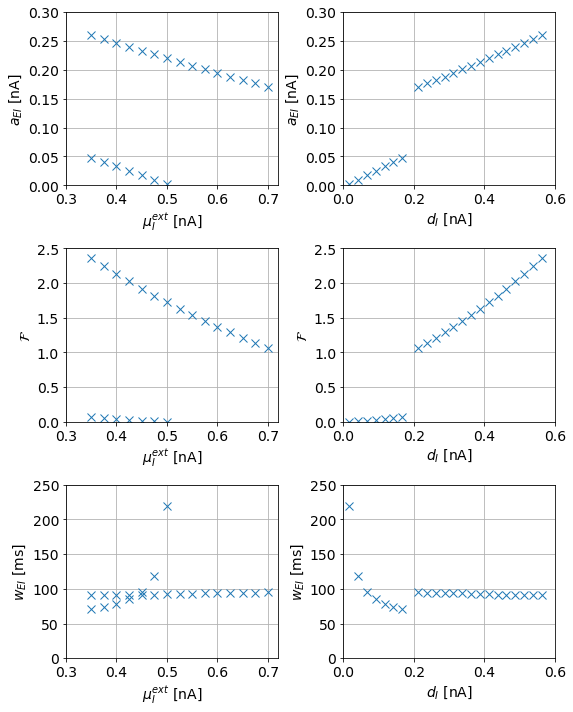

In [72]:
fig0, ax = plt.subplots(3,2, figsize = (8,10), facecolor='white')
fontsize_ = 14

for i in range(len(d_i)):
    if type(a_ei[i]) == type(None):
        continue
        
    if np.abs(a_ei[i]) > np.abs(a_ie[i]):
        ax[0,0].plot(mu_i[i], np.abs(a_ei[i]), marker='x', color=inh_blue, markersize=markersize_, linestyle='')
        ax[1,0].plot(mu_i[i], cost_tot[i], marker='x', color=inh_blue, markersize=markersize_, linestyle='')
        ax[2,0].plot(mu_i[i], w_ei[i], marker='x', color=inh_blue, markersize=markersize_, linestyle='')
        ax[0,1].plot(d_i[i], np.abs(a_ei[i]), marker='x', color=inh_blue, markersize=markersize_, linestyle='')
        ax[1,1].plot(d_i[i], cost_tot[i], marker='x', color=inh_blue, markersize=markersize_, linestyle='')
        ax[2,1].plot(d_i[i], w_ei[i], marker='x', color=inh_blue, markersize=markersize_, linestyle='')

for i in range(3):
    for j in range(2):
        ax[i,j].tick_params(axis='x', labelsize=fontsize_)
        ax[i,j].tick_params(axis='y', labelsize=fontsize_)
    
ax[0,0].set_xlabel(r'$\mu_I^{ext}$ [nA]', fontsize=fontsize_)
ax[0,0].set_ylabel(r'$a_{EI}$ [nA]', fontsize=fontsize_)
ax[1,0].set_xlabel(r'$\mu_I^{ext}$ [nA]', fontsize=fontsize_)
ax[1,0].set_ylabel(r'$\mathcal{F}$', fontsize=fontsize_)
ax[2,0].set_xlabel(r'$\mu_I^{ext}$ [nA]', fontsize=fontsize_)
ax[2,0].set_ylabel(r'$w_{EI}$ [ms]', fontsize=fontsize_)

ax[0,1].set_xlabel(r'$d_I$ [nA]', fontsize=fontsize_)
ax[0,1].set_ylabel(r'$a_{EI}$ [nA]', fontsize=fontsize_)
ax[1,1].set_xlabel(r'$d_I$ [nA]', fontsize=fontsize_)
ax[1,1].set_ylabel(r'$\mathcal{F}$', fontsize=fontsize_)
ax[2,1].set_xlabel(r'$d_I$ [nA]', fontsize=fontsize_)
ax[2,1].set_ylabel(r'$w_{EI}$ [ms]', fontsize=fontsize_)

for i in range(3):
    ax[i,0].set_xlim(0.3, 0.72)
    ax[i,1].set_xlim(0., 0.6)
    
for j in range(2):
    ax[0,j].set_ylim(0., 0.3)
    ax[1,j].set_ylim(0., 2.5)
    ax[2,j].set_ylim(0., 250)

fig0.tight_layout()
    
plt.savefig( os.path.join(os.getcwd(), 'rate_4'), facecolor=fig0.get_facecolor(), edgecolor='none',
            bbox_inches = 'tight', dpi=600)

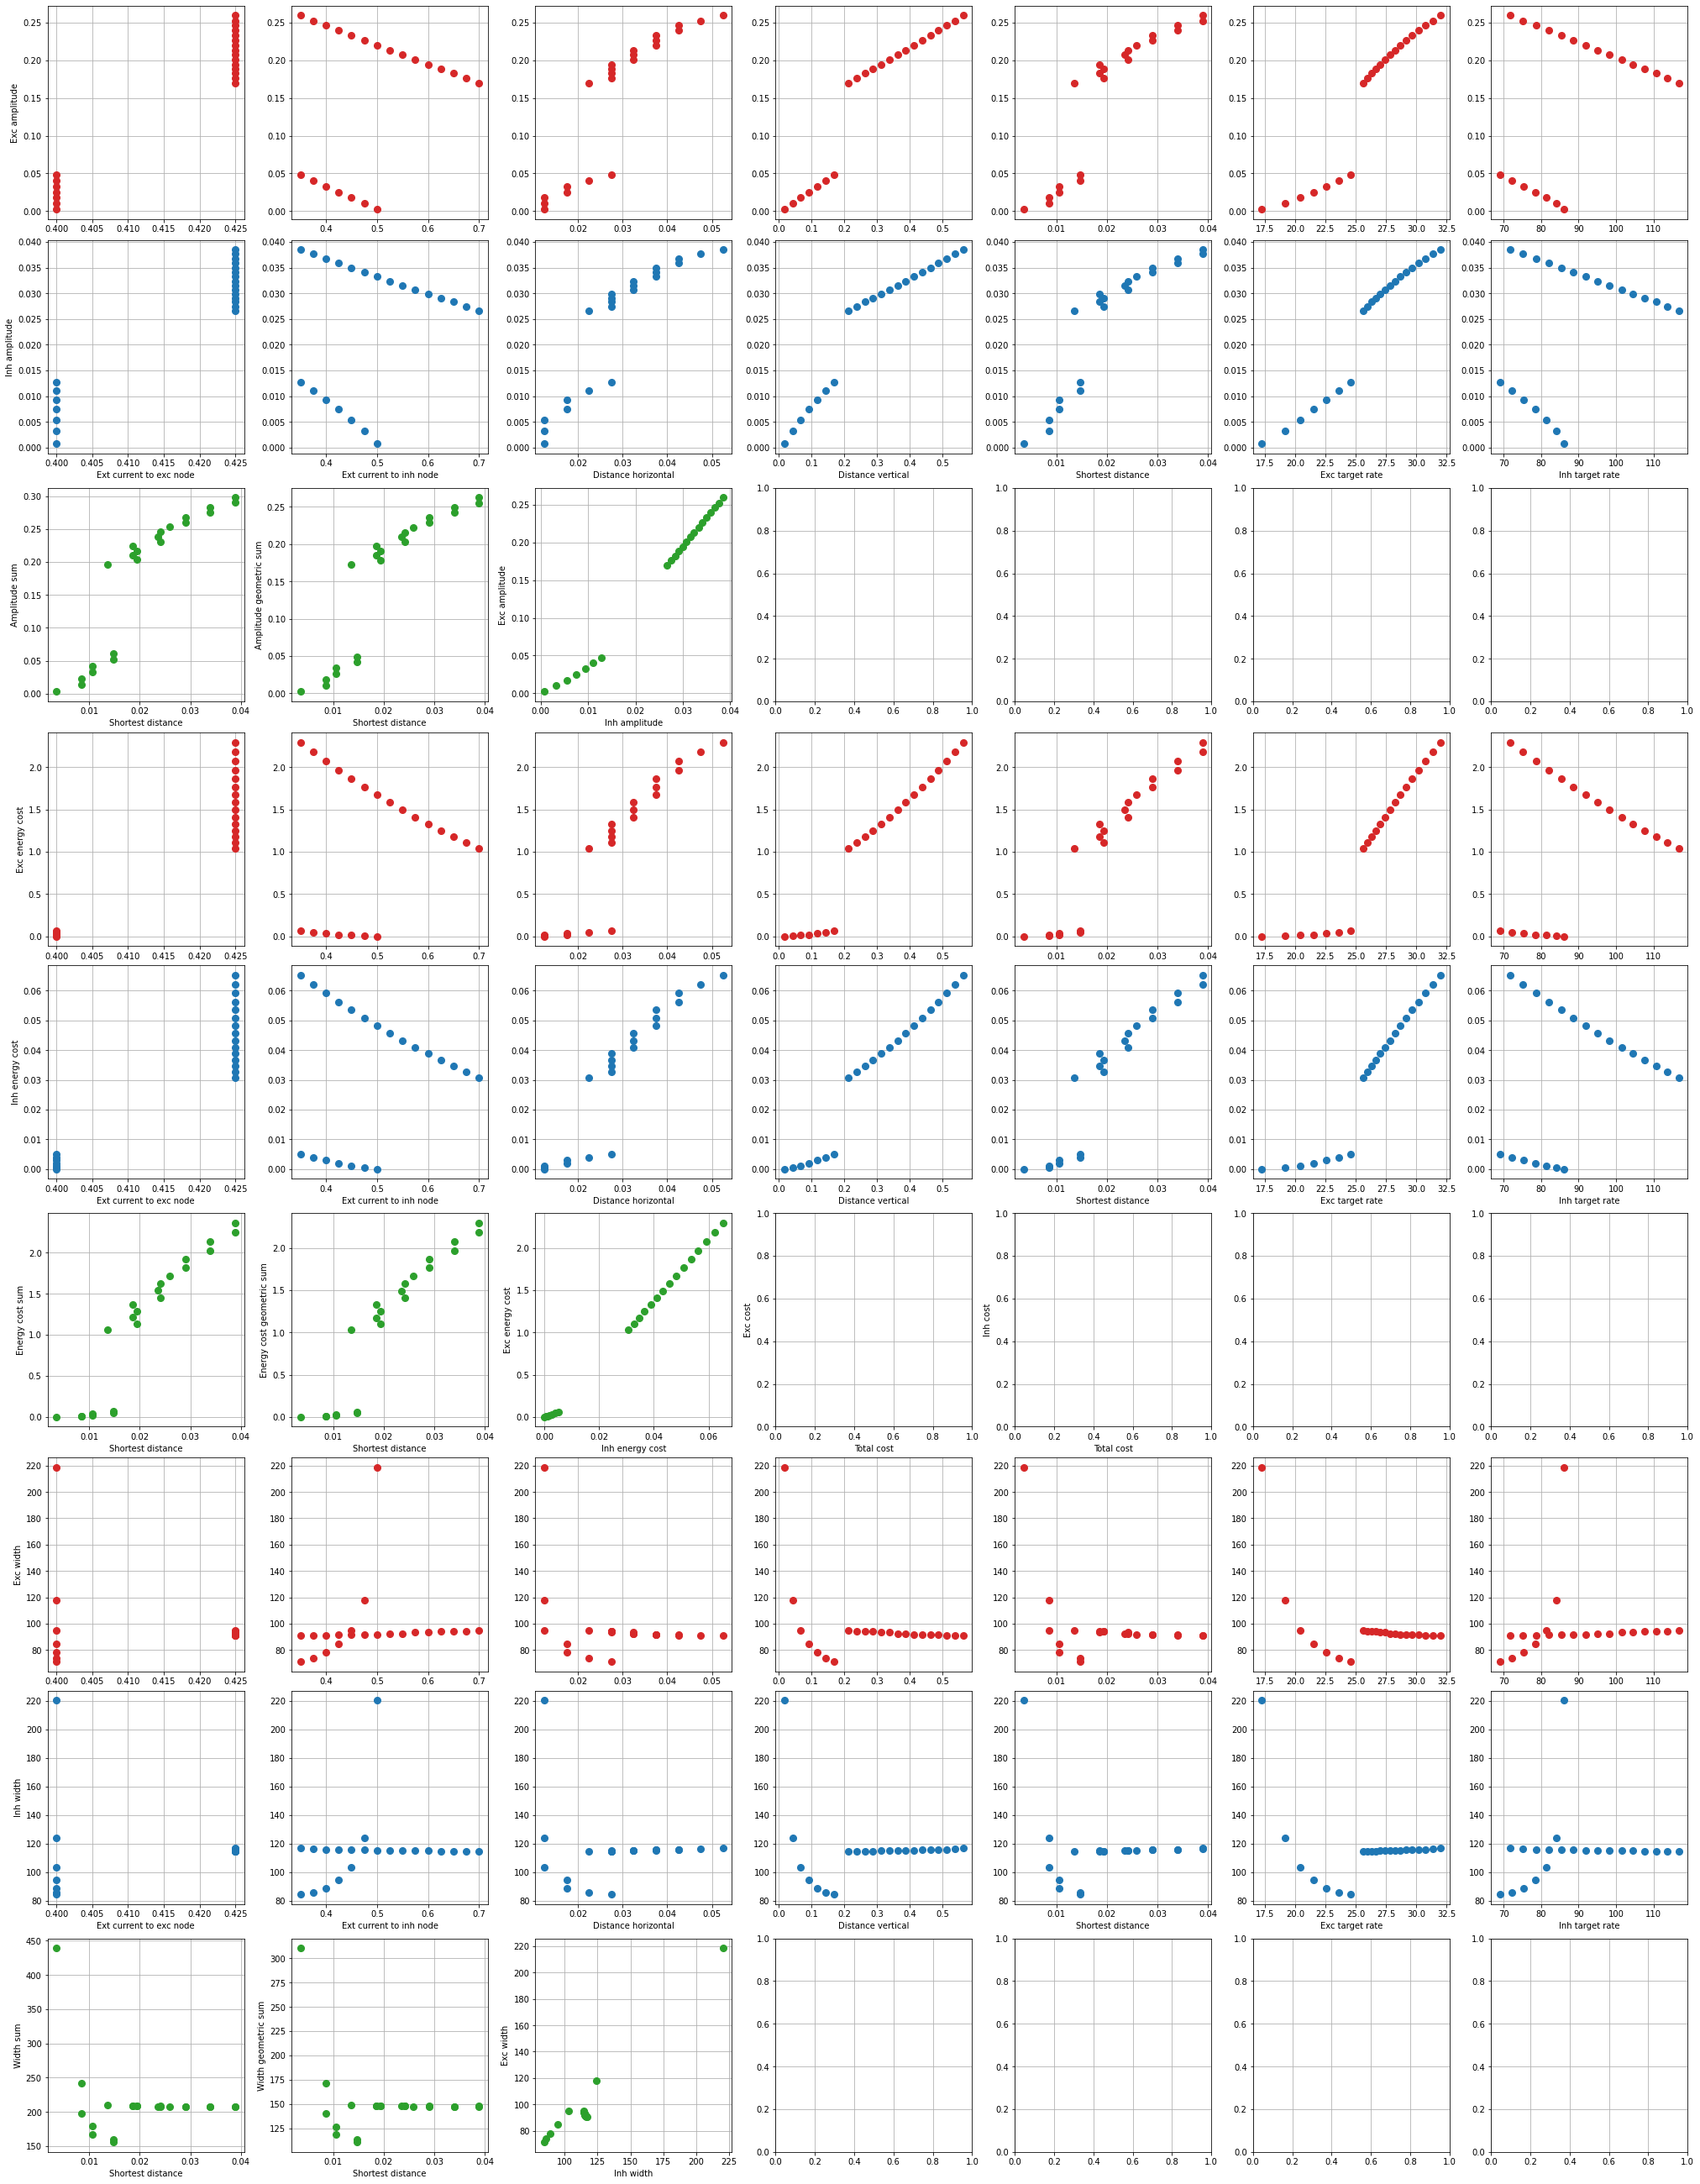

In [18]:
fig5c, axc = plt.subplots(9,7, constrained_layout=True, figsize = (28,36) ) # width, height
markersize_ = 8

y_axis = [a_ei, a_ie, cost_e_ei, cost_e_ie, w_ei, w_ie]
x_axis = [mu_e, mu_i, d_e, d_i, d_total, target_h_e, target_h_i]

fit_data_y_e = [[], [], [], [], [], []]
fit_data_y_i = [[], [], [], [], [], []]
fit_data_x_e = [[], [], [], [], [], [], []]
fit_data_x_i = [[], [], [], [], [], [], []]

fit_data_y_sum_e = [[], [], [], []]
fit_data_y_sum_i = [[], [], [], []]


fit_data = [[[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None, None], [None, None, None], [None, None, None], [None, None, None], [None, None, None],
                 [None, None, None], [None, None, None]],
            [[None, None, None], [None, None, None], [None, None, None], [None, None, None], [None, None, None],
                 [None, None, None], [None, None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]]]

fit_data_0 = [[[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]],
            [[None, None, None], [None, None, None], [None, None, None], [None, None, None], [None, None, None],
                 [None, None, None], [None, None, None]],
            [[None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]]]

#fit_data[6][7][2]= 1.

for i in range(len(d_e)):
    if type(a_ei[i]) == type(None):
        continue

    if np.abs(a_ie[i]) > np.abs(a_ei[i]):
        marker_ = 'x'
    else:
        marker_ = 'o'
        
    for x_ in range(len(x_axis)):
        x_data = x_axis[x_][i]
        if np.abs(a_ie[i]) > np.abs(a_ei[i]):
            fit_data_x_i[x_].append(x_data)
        elif np.abs(a_ie[i]) <= np.abs(a_ei[i]):
            fit_data_x_e[x_].append(x_data)
                
    for y_ in range(len(y_axis)):
        
        if y_ in [0,2,4]:
            color_ = exc_red
        else:
            color_ = inh_blue
        
        y_data = np.abs(y_axis[y_][i])
        if np.abs(a_ie[i]) > np.abs(a_ei[i]):
            fit_data_y_i[y_].append(y_data)
        elif np.abs(a_ie[i]) <= np.abs(a_ei[i]):
            fit_data_y_e[y_].append(y_data)
        
        for x_ in range(len(x_axis)):
            x_data = x_axis[x_][i]
            
            plot_y_ = y_
            if y_ > 1:
                plot_y_ += 1
            if y_ > 3:
                plot_y_ += 1
            axc[plot_y_,x_].plot(x_data, y_data, marker=marker_, color=color_, markersize=markersize_)
            
    axc[2,0].plot(d_total[i], np.abs(a_ei[i]) + np.abs(a_ie[i]), marker=marker_, color=green, markersize=markersize_)
    axc[2,1].plot(d_total[i], np.sqrt(a_ei[i]**2 + a_ie[i]**2), marker=marker_, color=green,
                  markersize=markersize_)
    axc[2,2].plot(np.abs(a_ie[i]), np.abs(a_ei[i]), marker=marker_, color=green, markersize=markersize_)
    
    if np.abs(a_ie[i]) > np.abs(a_ei[i]):
        fit_data_y_sum_i[0].append(np.abs(a_ei[i]) + np.abs(a_ie[i]))
        fit_data_y_sum_i[1].append(np.sqrt(a_ei[i]**2 + a_ie[i]**2))
    else:
        fit_data_y_sum_e[0].append(np.abs(a_ei[i]) + np.abs(a_ie[i]))
        fit_data_y_sum_e[1].append(np.sqrt(a_ei[i]**2 + a_ie[i]**2))
    
    axc[5,0].plot(d_total[i], cost_e_ei[i] + cost_e_ie[i], marker=marker_, color=green, markersize=markersize_)
    axc[5,1].plot(d_total[i], np.sqrt(cost_e_ei[i]**2 + cost_e_ie[i]**2), marker=marker_, color=green,
                  markersize=markersize_)
    axc[5,2].plot(cost_e_ie[i], cost_e_ei[i], marker=marker_, color=green, markersize=markersize_)
    
    if np.abs(a_ie[i]) > np.abs(a_ei[i]):
        fit_data_y_sum_i[2].append(np.abs(cost_e_ei[i]) + np.abs(cost_e_ie[i]))
        fit_data_y_sum_i[3].append(np.sqrt(cost_e_ei[i]**2 + cost_e_ie[i]**2))
    else:
        fit_data_y_sum_e[2].append(np.abs(cost_e_ei[i]) + np.abs(cost_e_ie[i]))
        fit_data_y_sum_e[3].append(np.sqrt(cost_e_ei[i]**2 + cost_e_ie[i]**2))
    
    axc[8,0].plot(d_total[i], w_ei[i] + w_ie[i], marker=marker_, color=green, markersize=markersize_)
    axc[8,1].plot(d_total[i], np.sqrt(w_ei[i]**2 + w_ie[i]**2), marker=marker_, color=green,
                  markersize=markersize_)
    axc[8,2].plot(w_ie[i], w_ei[i], marker=marker_, color=green, markersize=markersize_)
    
            
x_min_max = [[np.amin(x_) - 0.02, np.amax(x_) + 0.02] for x_ in fit_data_x_e]
x_ranges = [np.arange(x_min_max[x_][0], x_min_max[x_][1], 0.01) for x_ in range(len(x_min_max))]

"""
for x_ in range(len(x_axis)):
    if y_ == 0:
        
        color_ = exc_red
        popt, pcov = curve_fit(fit_func_lin, fit_data_x_e[x_], fit_data_y_e[y_])

        fit_data[y_][x_][0] = popt
        fit_data[y_][x_][1] = pcov
        label_ = ('({:.2f} '.format(fit_data[y_][x_][0][0]) + r'$\pm$' + ' {:.2f}'.format(fit_data[y_][x_][1][0,0])
                  + r')$\cdot x $+ ' + ' ({:.2f} '.format(fit_data[y_][x_][0][1]) + r'$\pm$'
                  + ' {:.2f} '.format(fit_data[y_][x_][1][1,1])
                  + ')'
                )
        axc[y_,x_].plot(x_ranges[x_], fit_func_lin(x_ranges[x_], fit_data[y_][x_][0][0], fit_data[y_][x_][0][1]),
                       color=color_, label = label_)
        axc[y_,x_].fill_between(x_ranges[x_], fit_func_lin(x_ranges[x_],
                fit_data[y_][x_][0][0] - fit_data[y_][x_][1][0,0], fit_data[y_][x_][0][1] - fit_data[y_][x_][1][1,1]),
                fit_func_lin(x_ranges[x_],
                fit_data[y_][x_][0][0] + fit_data[y_][x_][1][0,0], fit_data[y_][x_][0][1] + fit_data[y_][x_][1][1,1]),
                color=color_, alpha=0.2)
        
        axc[y_,x_].set_xlim(x_min_max[x_])
        axc[y_,x_].legend(loc='upper right', fontsize=10)
        
    if x_ not in [2,4,5]:
        continue
    if y_ == 2:
        
        color_ = exc_red
        popt, pcov = curve_fit(fit_func_quad, fit_data_x_e[x_], fit_data_y_e[y_])
        
        plot_y_ = y_ + 1

        fit_data[y_][x_][0] = popt
        fit_data[y_][x_][1] = pcov
        label_ = ('({:.2f} '.format(fit_data[y_][x_][0][0]) + r'$\pm$' + ' {:.2f}'.format(fit_data[y_][x_][1][0,0])
                  + r')$\cdot x^2 $+ '
                  + ' ({:.2f} '.format(fit_data[y_][x_][0][1]) + r'$\pm$' + ' {:.2f} '.format(fit_data[y_][x_][1][1,1])
                  + r')$\cdot x $+ ' + ' ({:.2f} '.format(fit_data[y_][x_][0][2]) + r'$\pm$'
                  + ' {:.2f} '.format(fit_data[y_][x_][1][2,2]) + ')'
                )
        axc[plot_y_,x_].plot(x_ranges[x_], fit_func_quad(x_ranges[x_], fit_data[y_][x_][0][0], fit_data[y_][x_][0][1],
                        fit_data[y_][x_][0][2]), color=color_, label = label_)
        #axc[plot_y_,x_].fill_between(x_ranges[x_], fit_func_quad(x_ranges[x_],
        #        fit_data[y_][x_][0][0] - fit_data[y_][x_][1][0,0], fit_data[y_][x_][0][1] - fit_data[y_][x_][1][1,1],
        #        fit_data[y_][x_][0][2] - fit_data[y_][x_][1][2,2]), fit_func_quad(x_ranges[x_],
        #        fit_data[y_][x_][0][0] + fit_data[y_][x_][1][0,0], fit_data[y_][x_][0][1] + fit_data[y_][x_][1][1,1],
        #        fit_data[y_][x_][0][2] + fit_data[y_][x_][1][2,2]), color=color_, alpha=0.2)

plot_fit_func(fit_func_lin, axc[2,0], fit_data_x_e[4], fit_data_y_sum_e[0], exc_red)
plot_fit_func(fit_func_lin, axc[2,1], fit_data_x_e[4], fit_data_y_sum_e[1], exc_red)

plot_fit_func(fit_func_quad, axc[5,0], fit_data_x_e[4], fit_data_y_sum_e[2], exc_red)
plot_fit_func(fit_func_quad, axc[5,1], fit_data_x_e[4], fit_data_y_sum_e[3], exc_red)

plot_fit_func(fit_func_lin, axc[8,2], fit_data_y_e[5], fit_data_y_e[4], exc_red)

plot_yellow = [[0,2], [2,1], [2,2], [3,2], [3,4], [5,1], [6,2], [6,4], [8,2]]

for i in range(len(plot_yellow)):
    axc[plot_yellow[i][0], plot_yellow[i][1]].patch.set_facecolor('yellow')
    axc[plot_yellow[i][0], plot_yellow[i][1]].patch.set_alpha(0.3)
"""

setlabels_energy(axc)
       
plt.savefig( os.path.join(os.getcwd(), 'A_all_4.png') )
plt.show()

In [31]:
def plot_fit_func(func_, ax_, fit_data_x_, fit_data_y_, color_, setxlim=True):
    fit_data = [None, None]
    x_min_max = [max(0., np.amin(fit_data_x_) - 0.02), np.amax(fit_data_x_) + 0.02]
    x_range = np.arange(x_min_max[0], x_min_max[1], 0.01)
    popt, pcov = curve_fit(func_, fit_data_x_, fit_data_y_)
    fit_data[0] = popt
    fit_data[1] = pcov
        
    if fit_data[1].shape[0] <= 2:
        fontsize_ = 10
        label_ = ('({:.2f} '.format(fit_data[0][0]) + r'$\pm$' + ' {:.2f}'.format(fit_data[1][0,0])
                    + r')$\cdot x $+ ' + ' ({:.2f} '.format(fit_data[0][1]) + r'$\pm$'
                    + ' {:.2f} '.format(fit_data[1][1,1])
                    + ')'
                    )
        ax_.plot(x_range, func_(x_range, fit_data[0][0], fit_data[0][1]),
                               color=color_, label = label_)
        ax_.fill_between(x_range, func_(x_range, fit_data[0][0] - fit_data[1][0,0],
                        fit_data[0][1] - fit_data[1][1,1]), func_(x_range, fit_data[0][0] + fit_data[1][0,0],
                        fit_data[0][1] + fit_data[1][1,1]), color=color_, alpha=0.2)
    
    else:
        fontsize_ = 6
        label_ = ('({:.2f} '.format(fit_data[0][0]) + r'$\pm$' + ' {:.2f}'.format(fit_data[1][0,0])
                  + r')$\cdot x^2 $+ '
                  + ' ({:.2f} '.format(fit_data[0][1]) + r'$\pm$' + ' {:.2f} '.format(fit_data[1][1,1])
                  + r')$\cdot x $+ ' + ' ({:.2f} '.format(fit_data[0][2]) + r'$\pm$'
                  + ' {:.2f} '.format(fit_data[1][2,2]) + ')'
                )
        ax_.plot(x_range, fit_func_quad(x_range, fit_data[0][0], fit_data[0][1],
                        fit_data[0][2]), color=color_, label = label_)
        #ax_.fill_between(x_ranges[x_], fit_func_quad(x_ranges[x_],
        #        fit_data[0][0] - fit_data[1][0,0], fit_data[0][1] - fit_data[1][1,1],
        #        fit_data[0][2] - fit_data[1][2,2]), fit_func_quad(x_ranges[x_],
        #        fit_data[0][0] + fit_data[1][0,0], fit_data[0][1] + fit_data[1][1,1],
        #        fit_data[0][2] + fit_data[1][2,2]), color=color_, alpha=0.2)
    
    if setxlim:
        ax_.set_xlim(x_min_max)
    ax_.legend(loc='upper right', fontsize=fontsize_)